### Purpose of this notebook

- Generate a bunch of worlds and analyze their relational properties to help identify which are interesting, and to measure those properties in the population


In [182]:
from __future__ import division

import numpy as np
import os, sys
from PIL import Image

from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

from IPython.core.pylabtools import figsize, getfigs

import seaborn as sns

import random

from scipy.stats import norm
from IPython.display import clear_output

import copy
import importlib


### Add Paths

## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths

## add helpers to python path
import sys
if os.path.join(proj_dir, 'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'stimuli'))

## custom helper modules
import blockworld_helpers as utils

In [231]:
importlib.reload(utils)

<module 'blockworld_helpers' from '/Users/will/compositional-abstractions/stimuli/blockworld_helpers.py'>

### generate stimuli for norming/ prior study

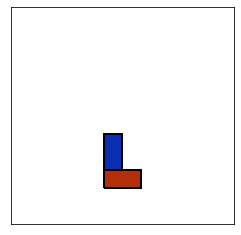

In [47]:
block_dims = [(2,1),(1,2)]
block_colors = ['#B32F0A','#0A2FB3']
world_width = 8
world_height = 8
world_center = int((world_width-1)/2)

w = utils.World(block_dims = block_dims,
                block_colors = block_colors)

w.add_block(2,1,world_center,0)
w.snap_to_floor(1,2,world_center)
utils.draw_world(w)

In [38]:
w.get_block_dict()['blocks']

[{'x': 3, 'y': 0, 'height': 1, 'width': 2}]

In [49]:
# generate stims

stims = {}

# single blocks
stims[1] = []

for block in block_dims:
    w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
    w.add_block(block[0], # width
                block[1], # height
                world_center,0)
    stims[1].append(w.get_block_dict()['blocks'])

{1: [[{'x': 3, 'y': 0, 'height': 1, 'width': 2}],
  [{'x': 3, 'y': 0, 'height': 2, 'width': 1}]]}

In [57]:
# two-block stims
stims[2] = []

# add block in position
for blocks in stims[1]:    
    for block in block_dims:
        for x in range(0, world_width-1):
            #repopulate world
            w = utils.World(block_dims = block_dims,
            block_colors = block_colors)
            w.populate_from_block_list(blocks)
    
            #add new block
            w.snap_to_floor(block[0], # width
                        block[1], # height
                        x)
            stims[2].append(w.get_block_dict()['blocks'])


In [59]:
# three-block stims
stims[3] = []

# add block in position
for blocks in stims[2]:    
    for block in block_dims:
        for x in range(0, world_width-1):
            #repopulate world
            w = utils.World(block_dims = block_dims,
            block_colors = block_colors)
            w.populate_from_block_list(blocks)
    
            #add new block
            w.snap_to_floor(block[0], # width
                        block[1], # height
                        x)
            stims[3].append(w.get_block_dict()['blocks'])


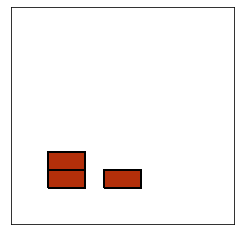

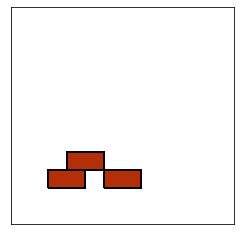

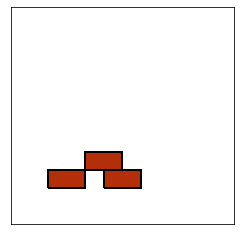

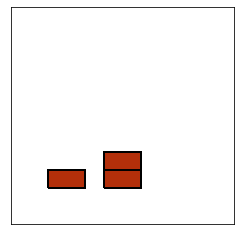

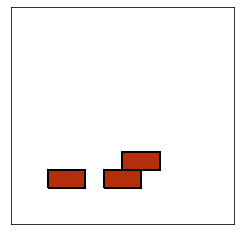

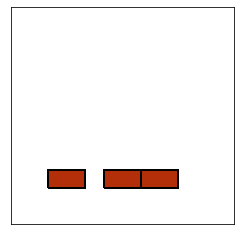

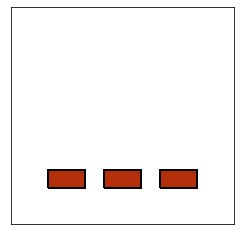

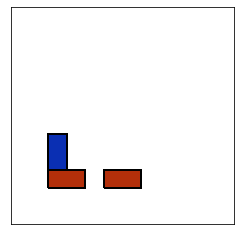

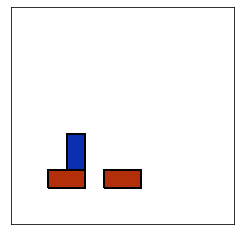

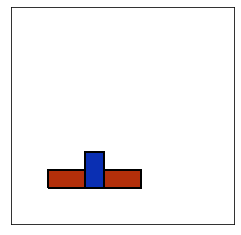

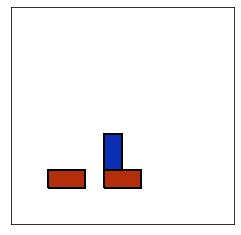

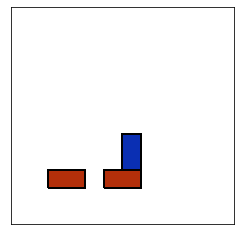

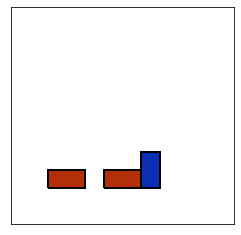

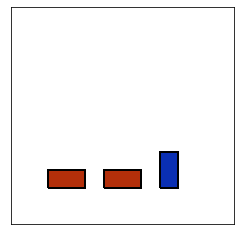

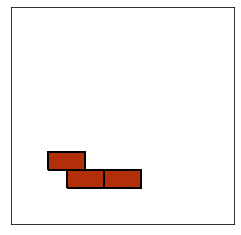

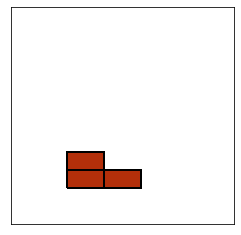

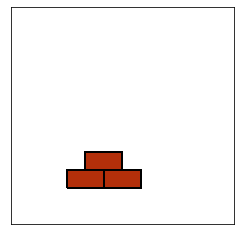

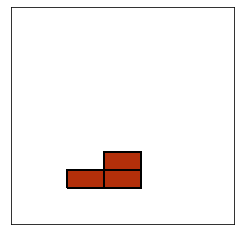

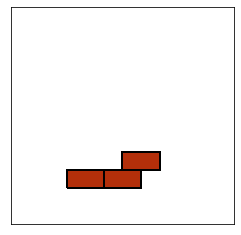

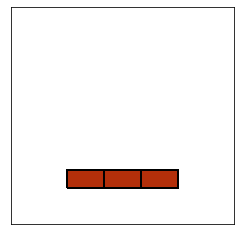

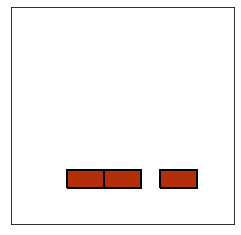

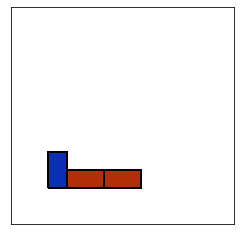

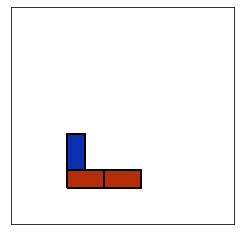

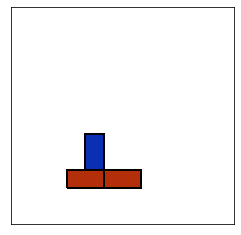

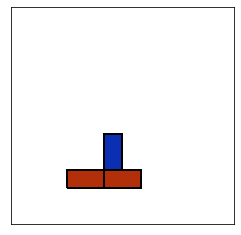

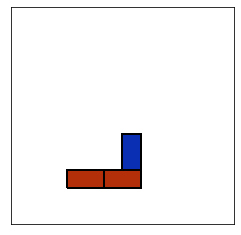

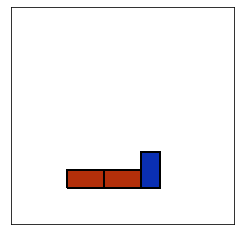

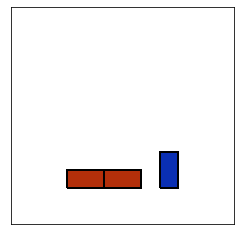

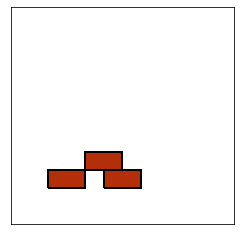

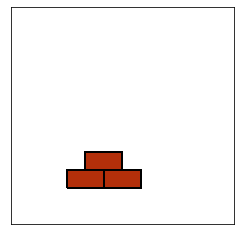

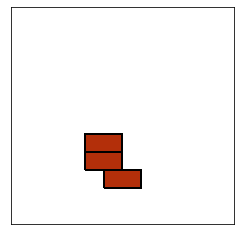

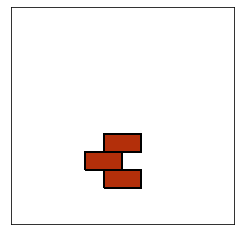

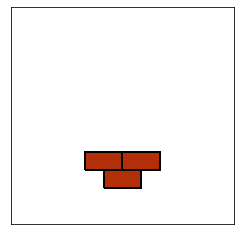

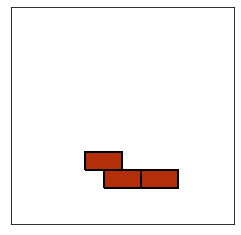

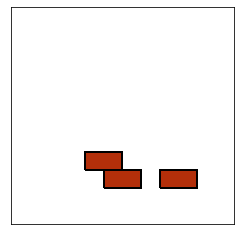

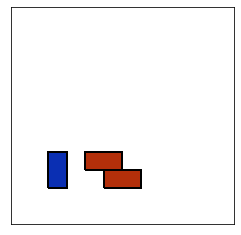

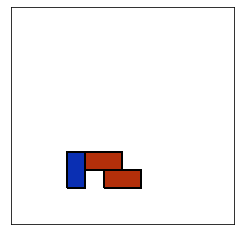

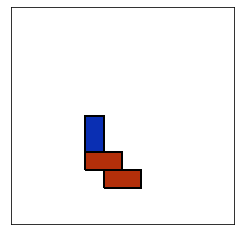

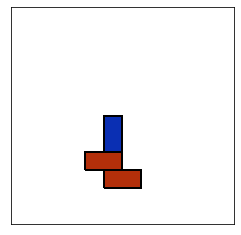

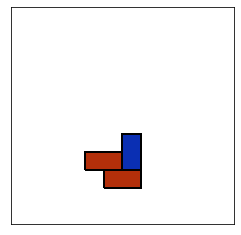

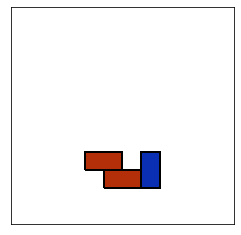

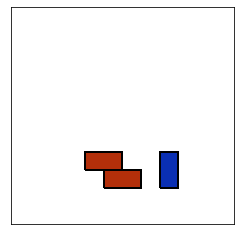

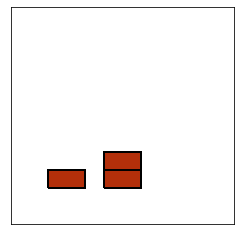

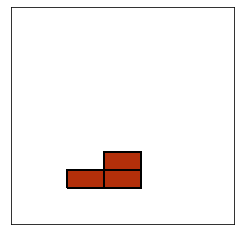

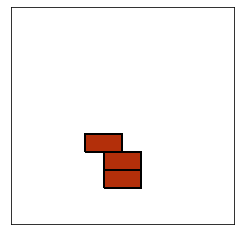

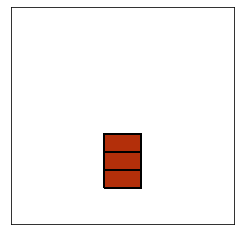

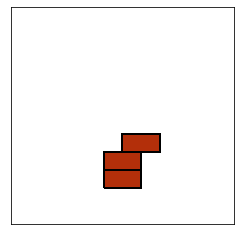

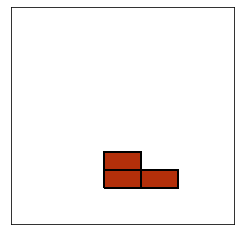

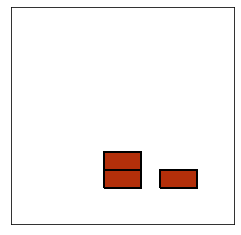

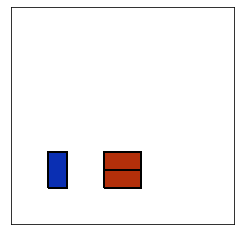

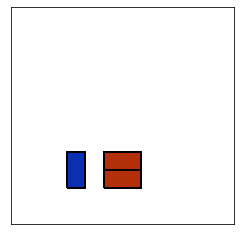

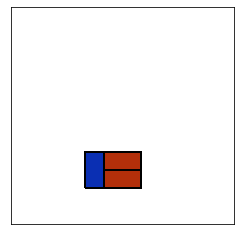

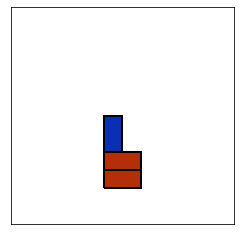

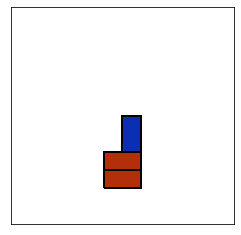

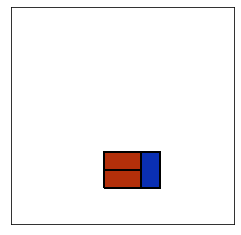

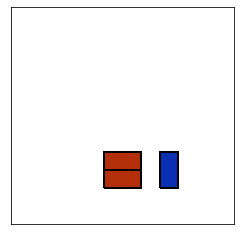

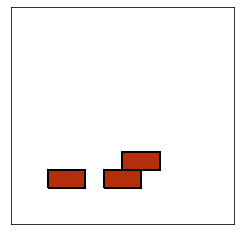

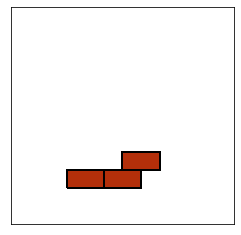

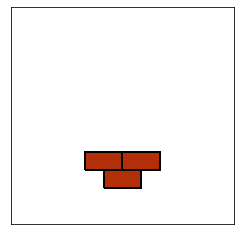

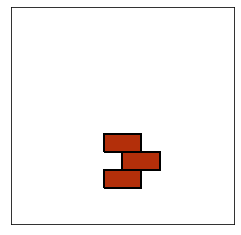

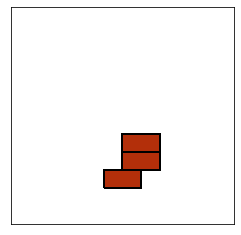

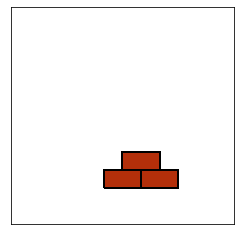

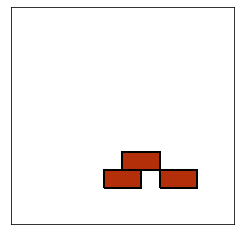

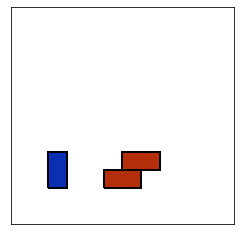

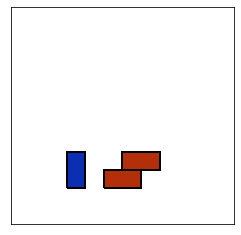

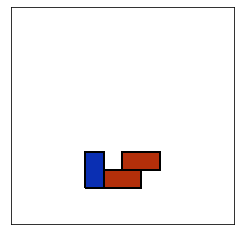

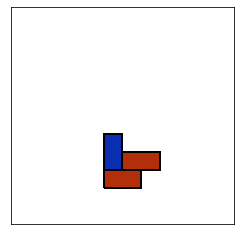

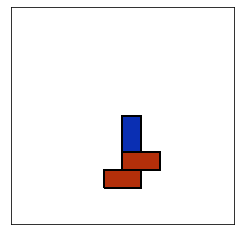

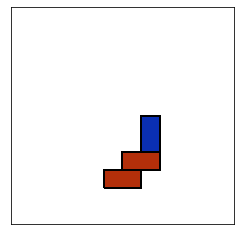

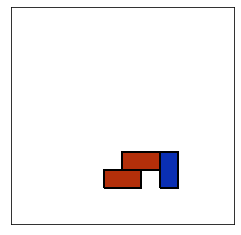

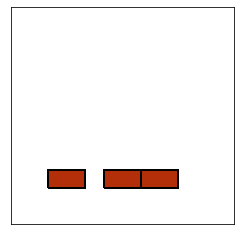

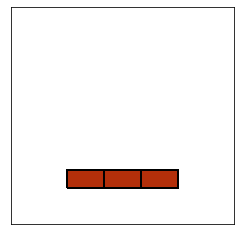

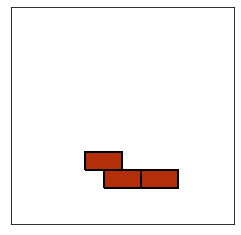

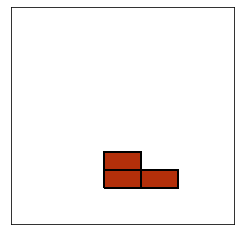

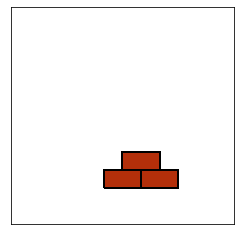

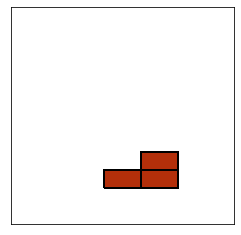

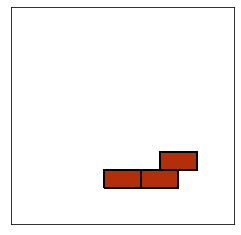

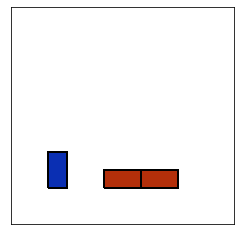

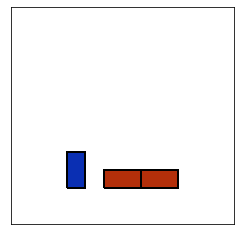

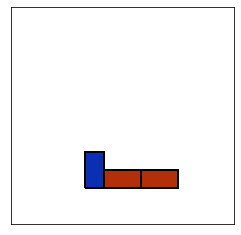

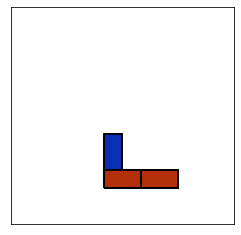

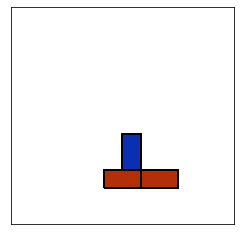

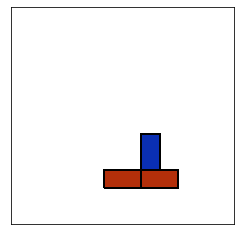

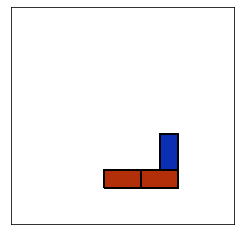

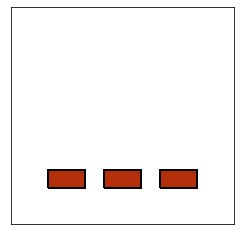

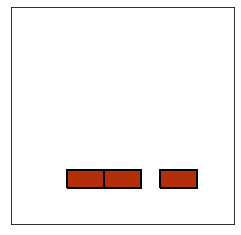

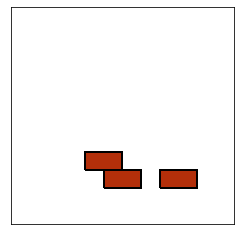

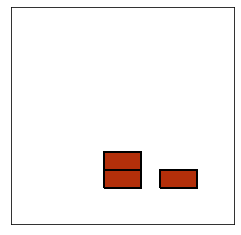

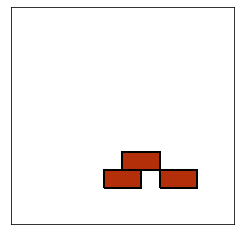

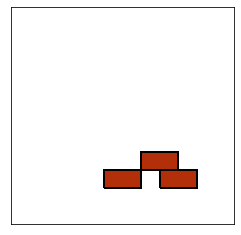

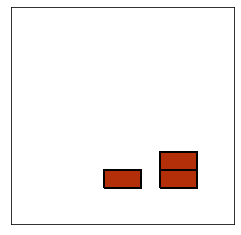

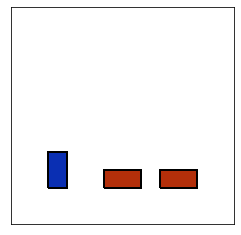

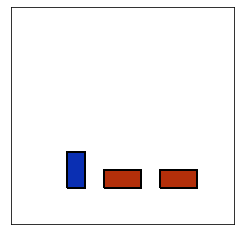

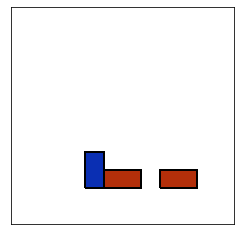

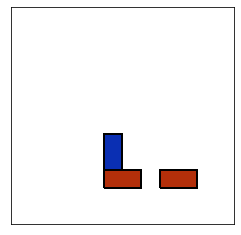

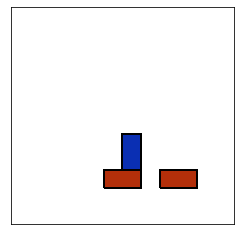

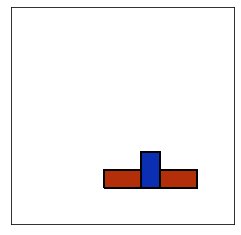

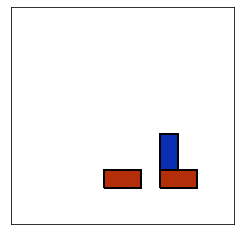

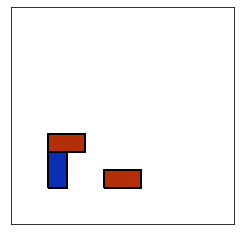

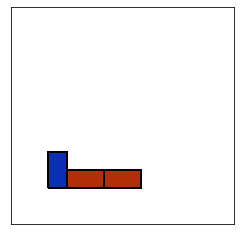

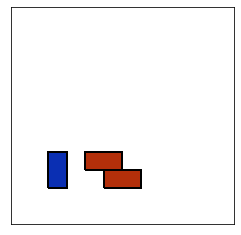

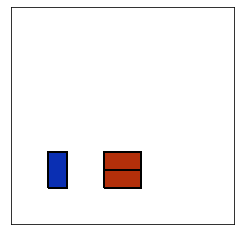

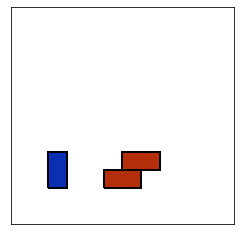

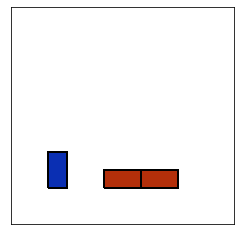

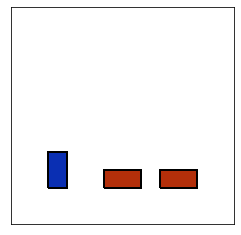

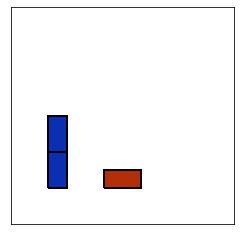

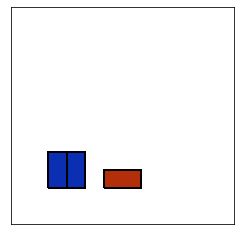

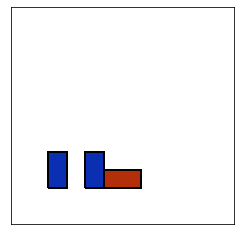

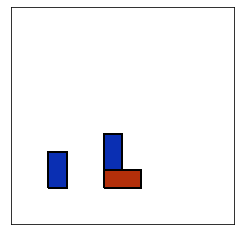

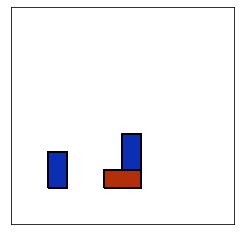

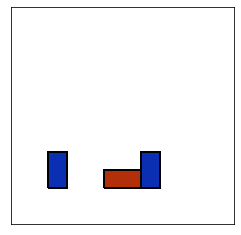

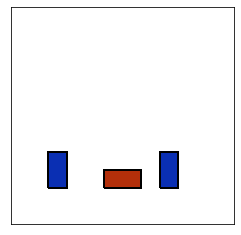

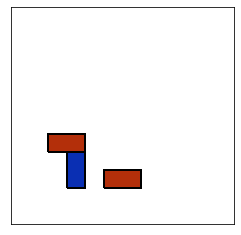

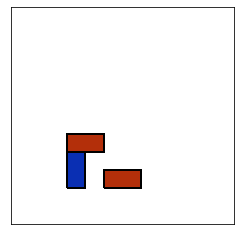

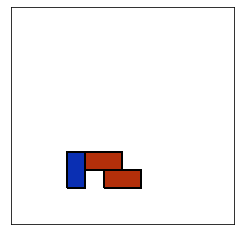

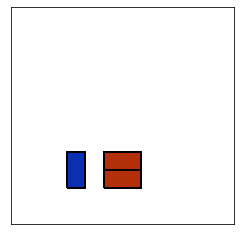

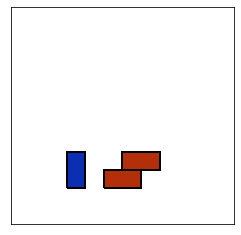

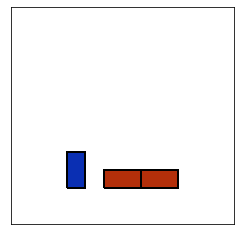

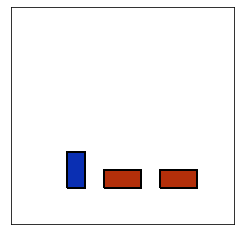

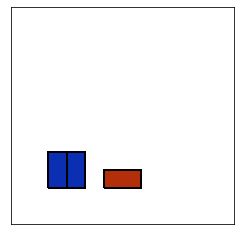

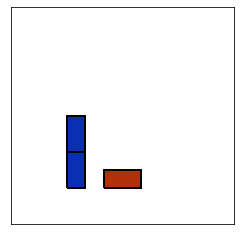

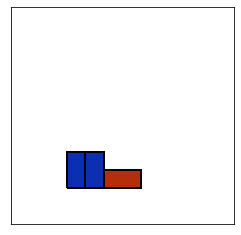

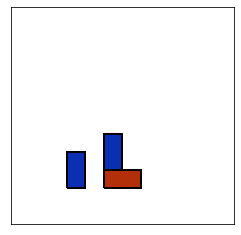

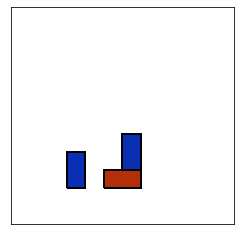

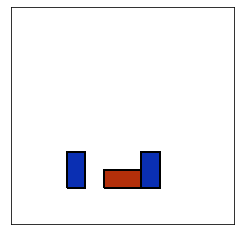

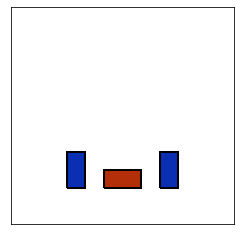

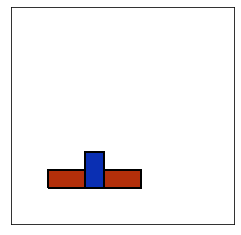

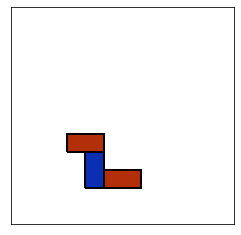

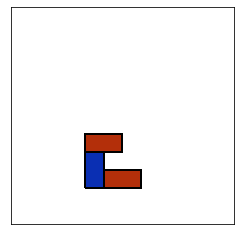

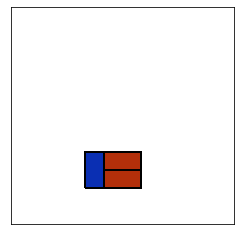

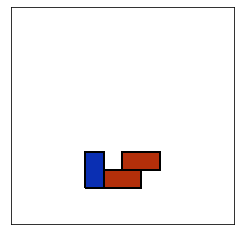

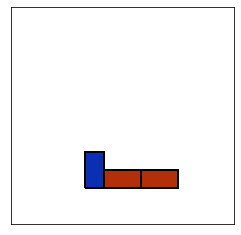

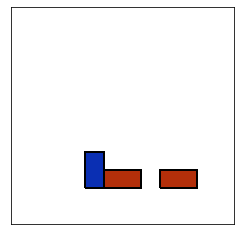

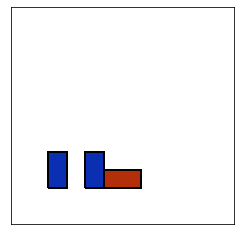

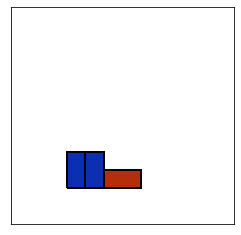

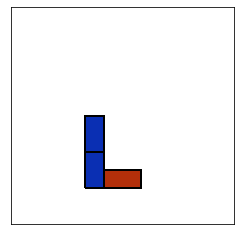

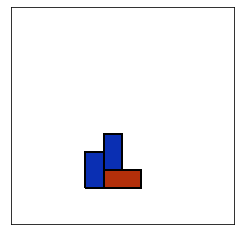

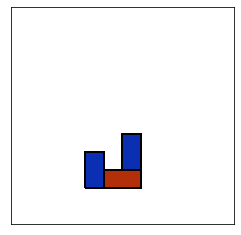

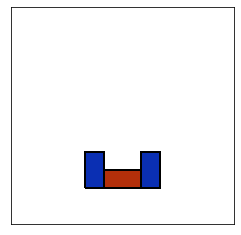

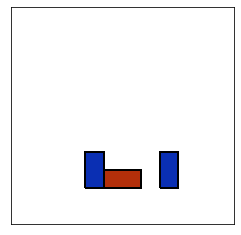

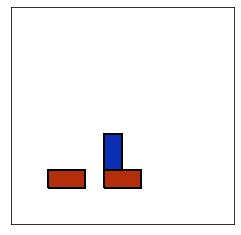

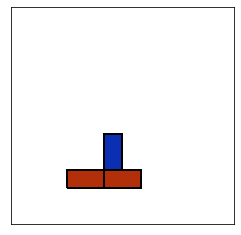

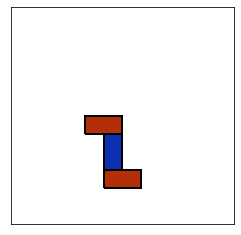

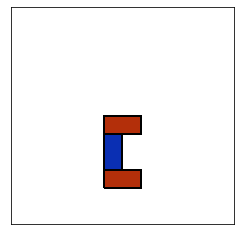

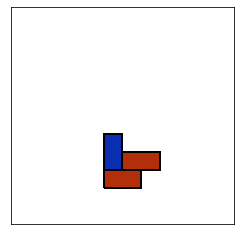

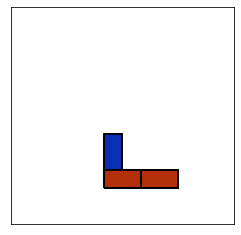

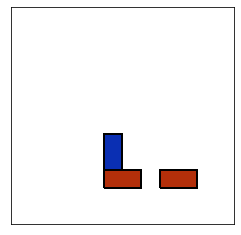

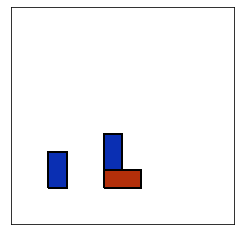

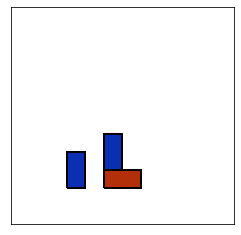

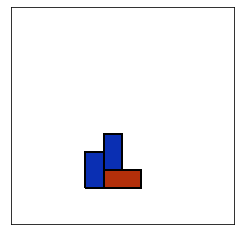

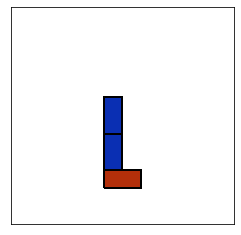

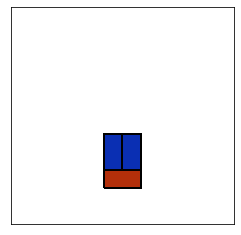

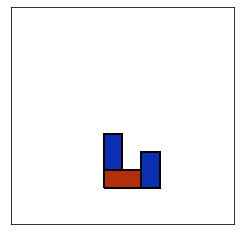

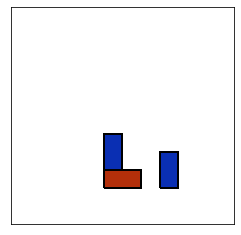

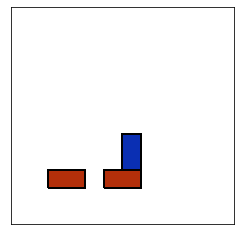

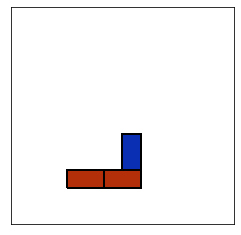

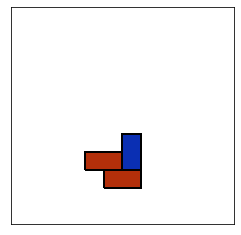

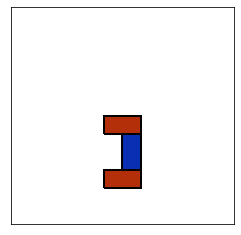

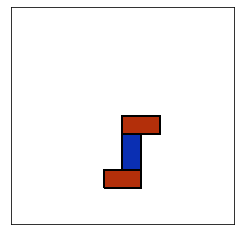

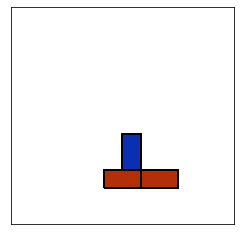

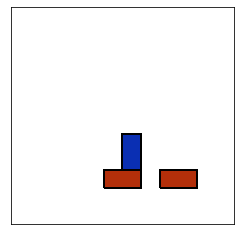

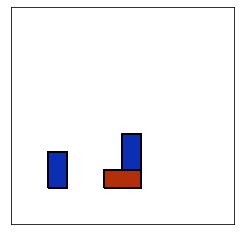

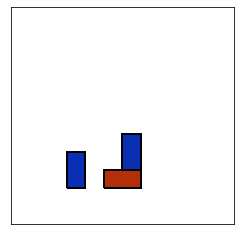

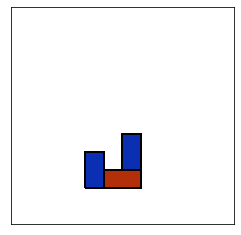

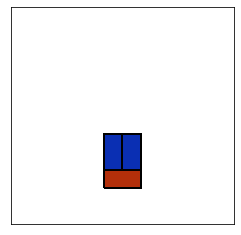

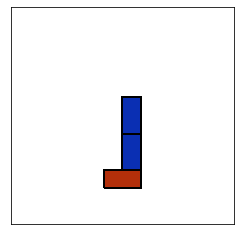

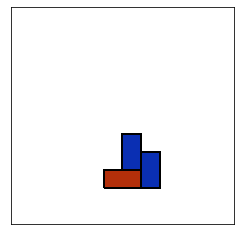

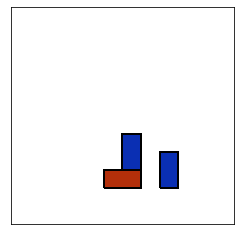

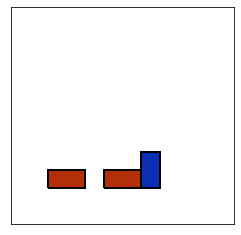

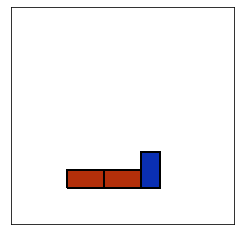

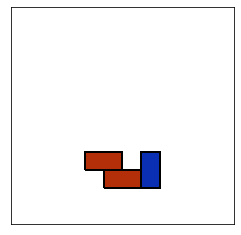

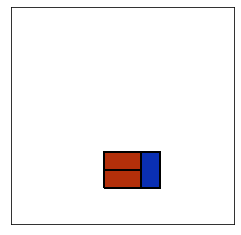

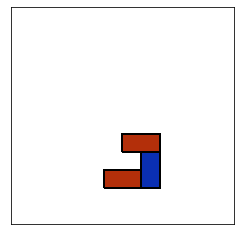

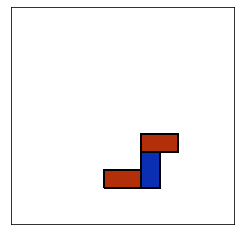

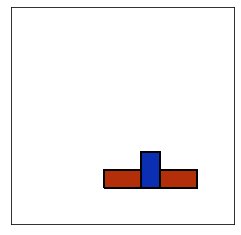

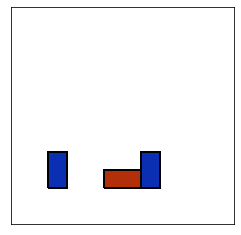

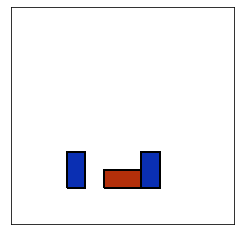

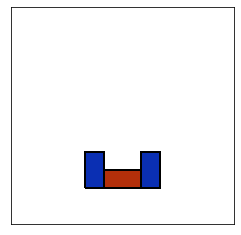

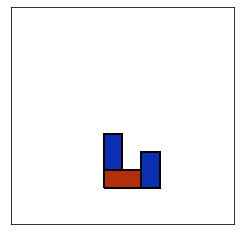

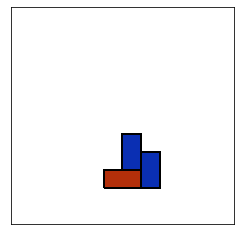

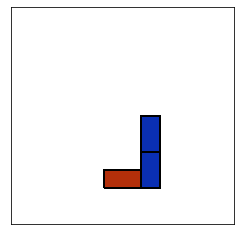

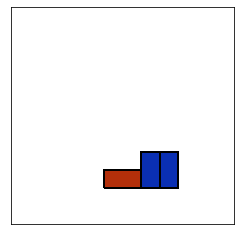

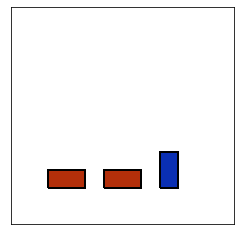

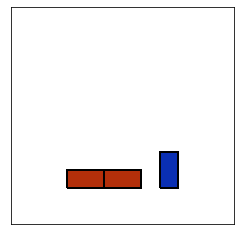

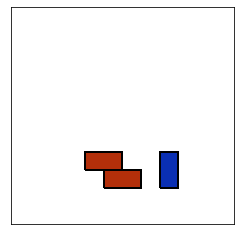

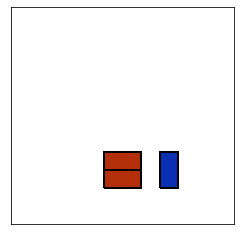

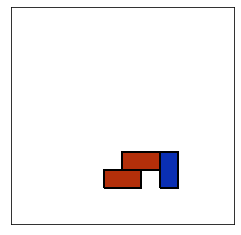

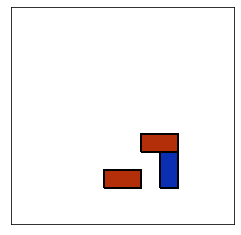

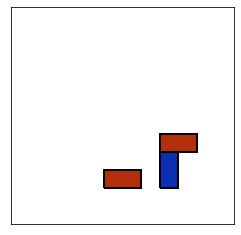

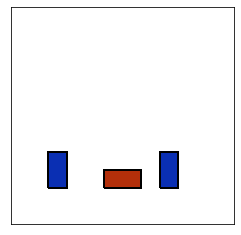

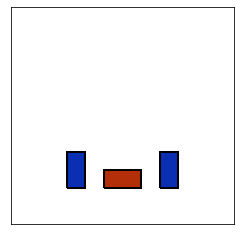

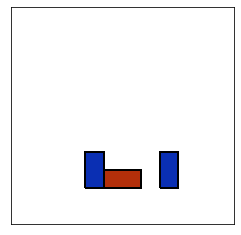

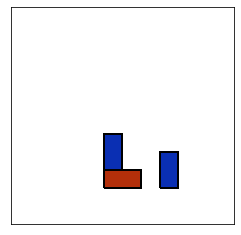

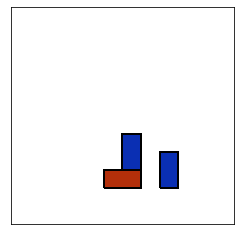

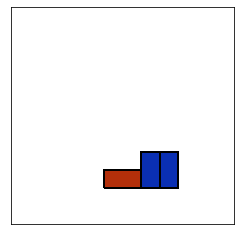

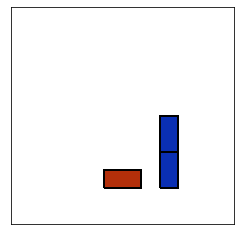

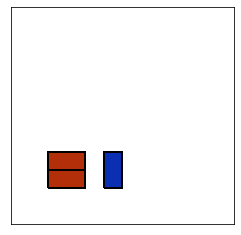

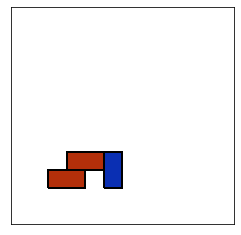

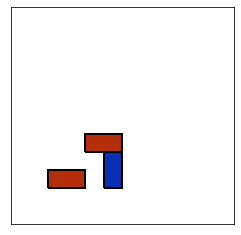

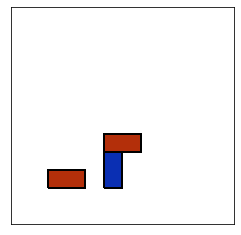

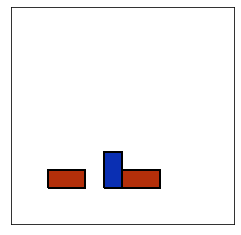

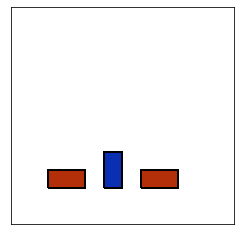

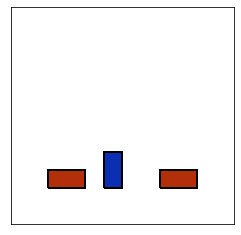

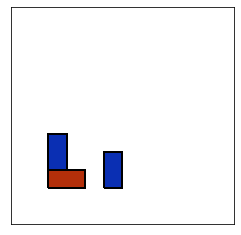

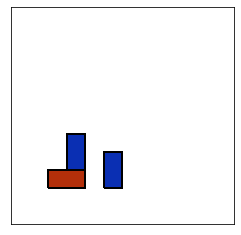

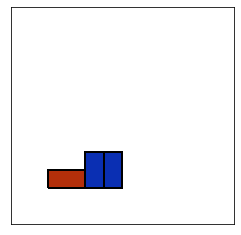

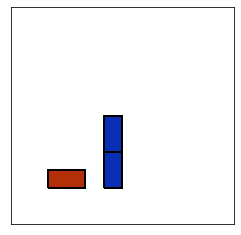

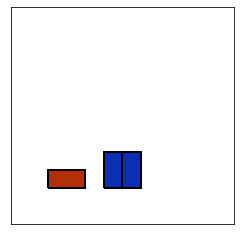

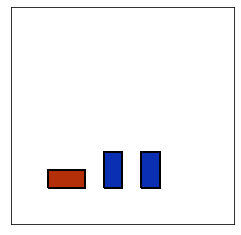

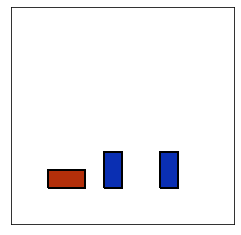

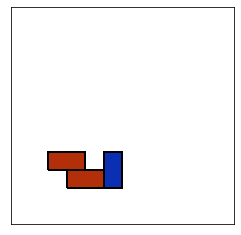

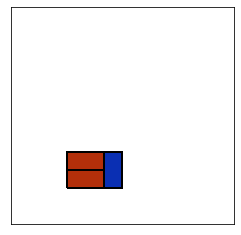

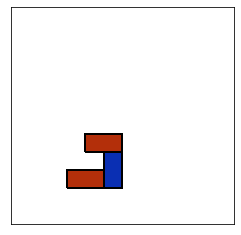

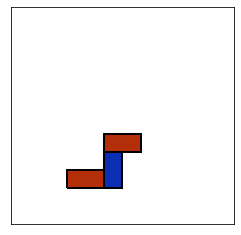

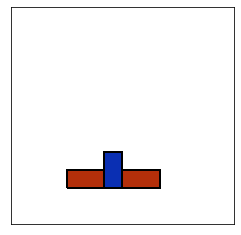

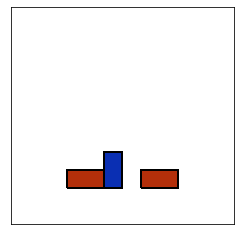

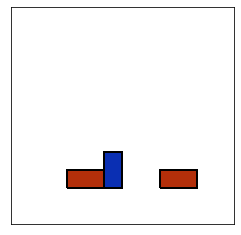

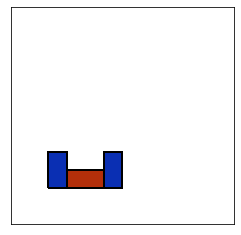

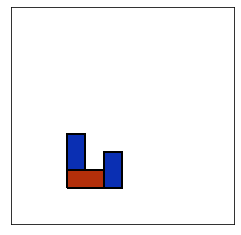

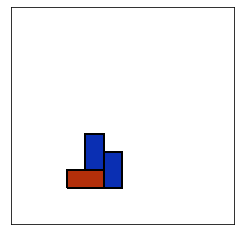

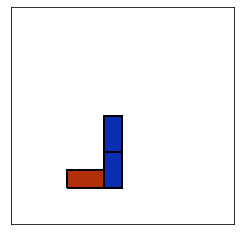

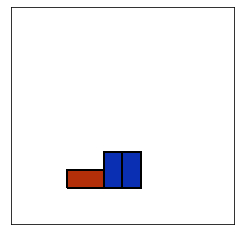

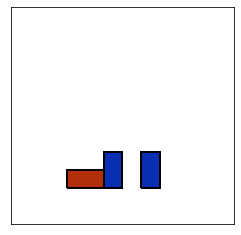

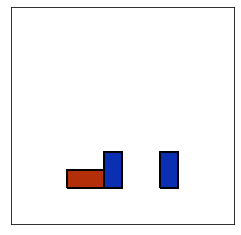

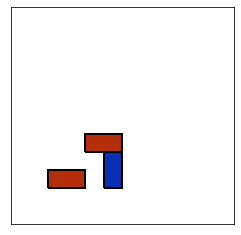

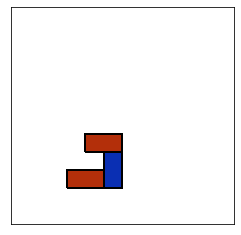

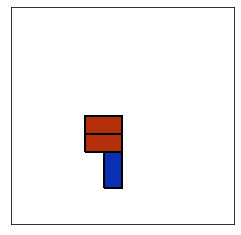

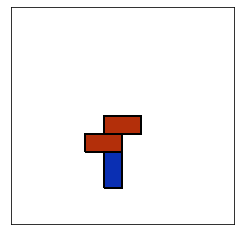

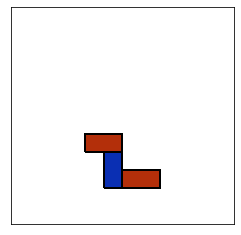

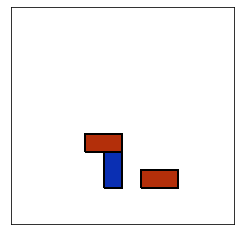

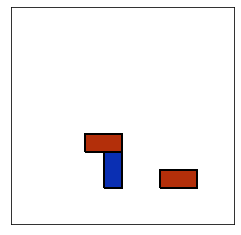

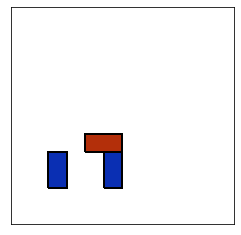

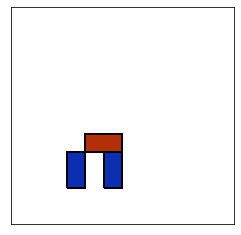

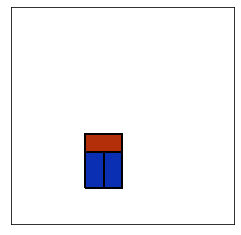

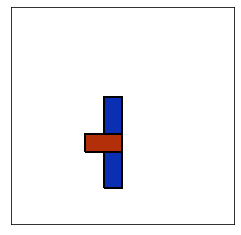

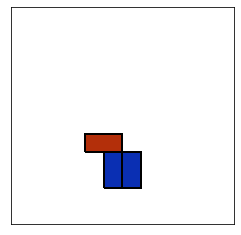

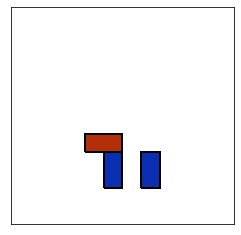

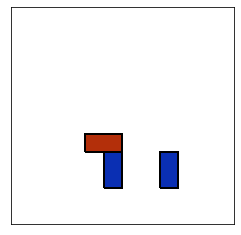

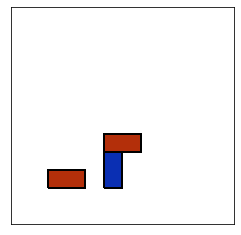

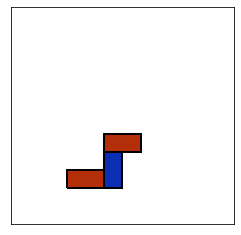

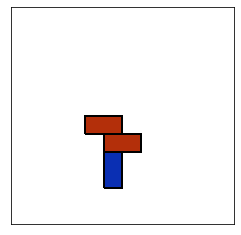

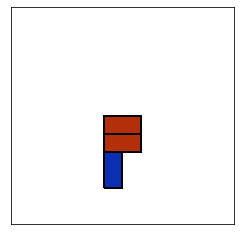

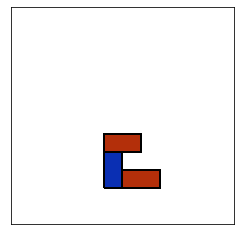

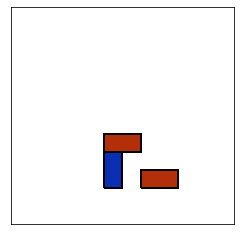

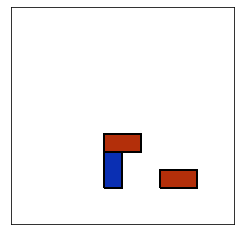

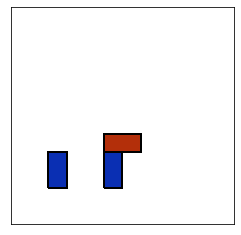

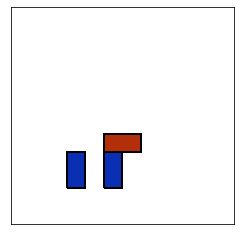

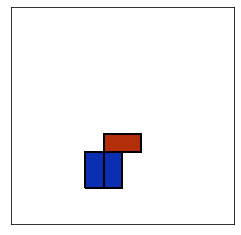

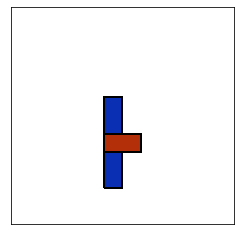

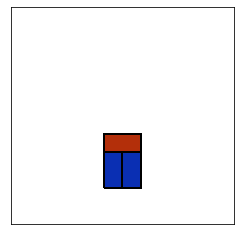

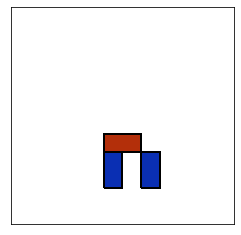

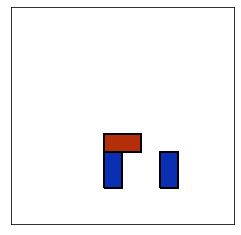

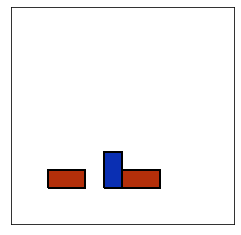

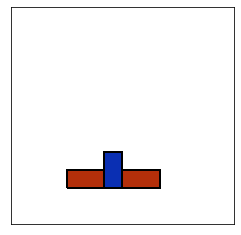

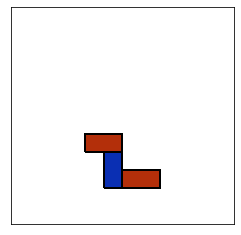

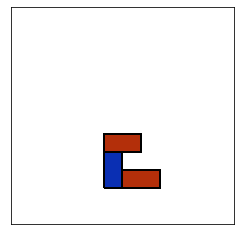

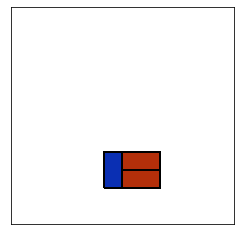

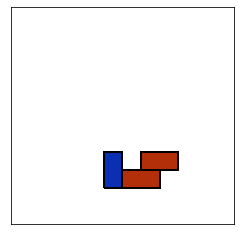

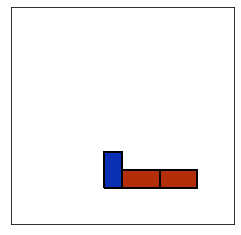

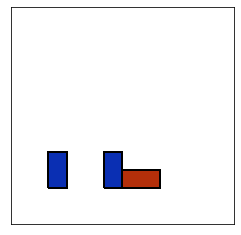

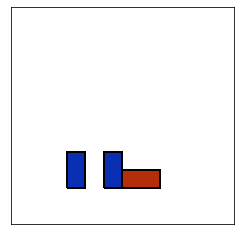

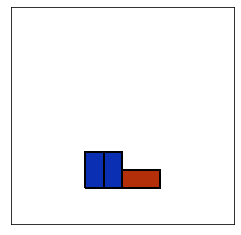

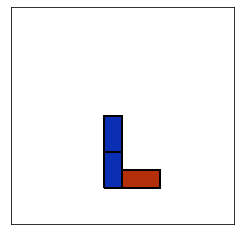

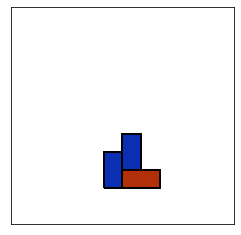

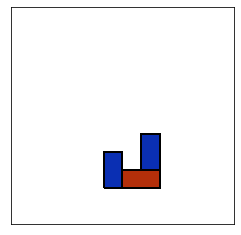

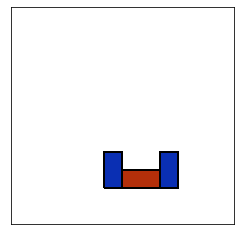

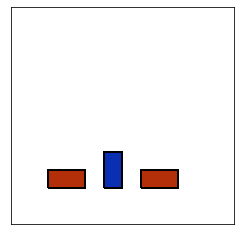

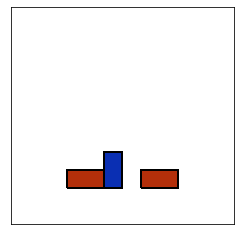

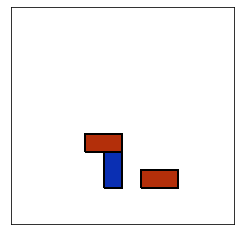

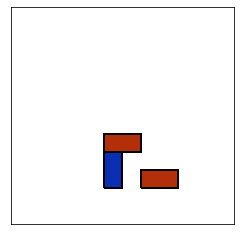

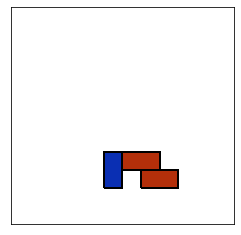

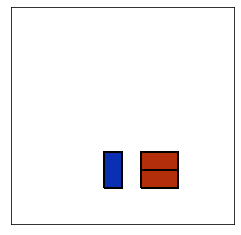

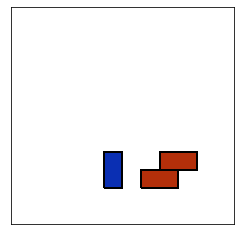

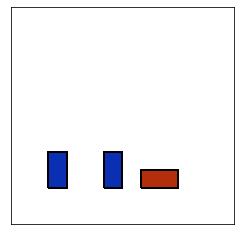

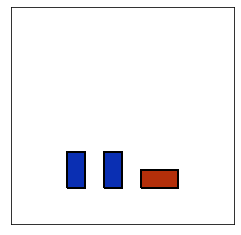

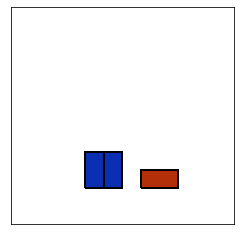

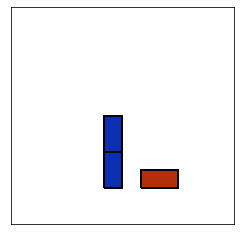

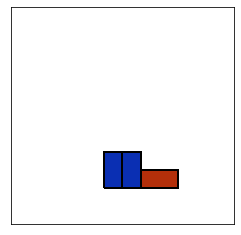

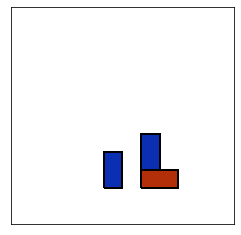

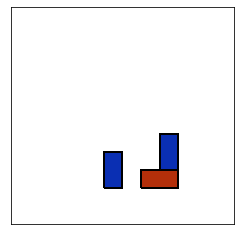

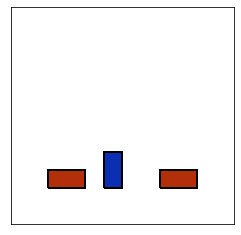

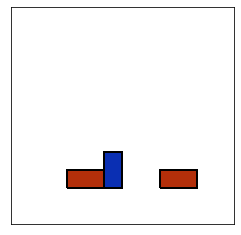

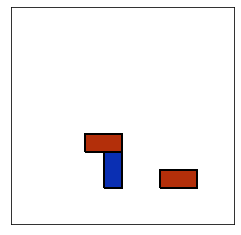

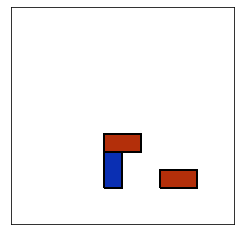

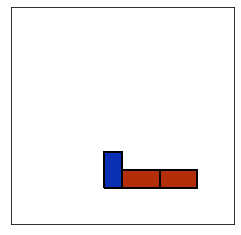

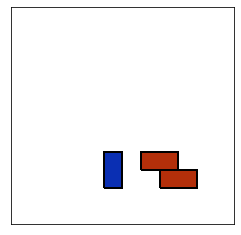

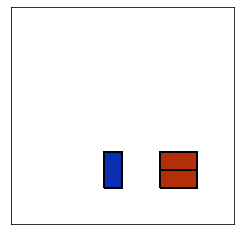

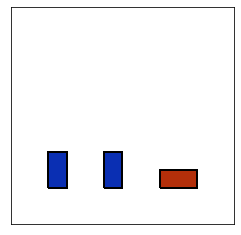

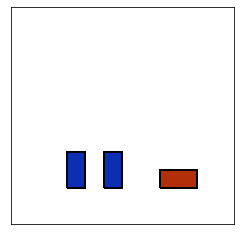

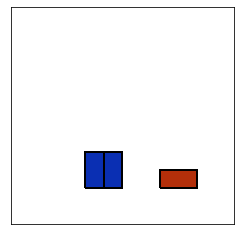

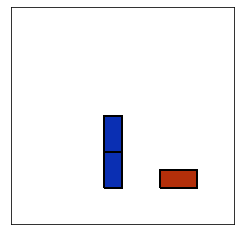

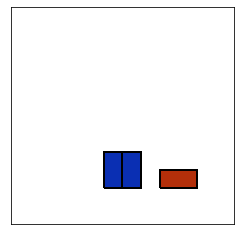

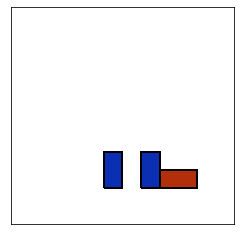

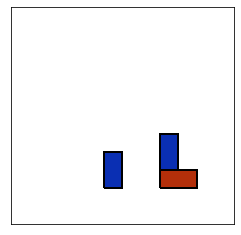

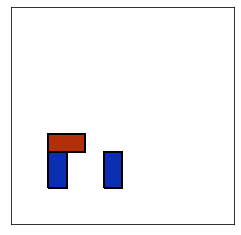

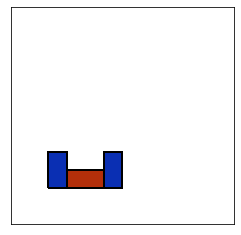

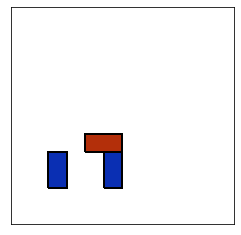

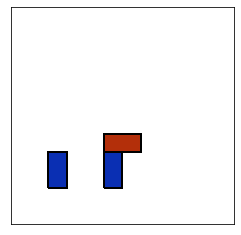

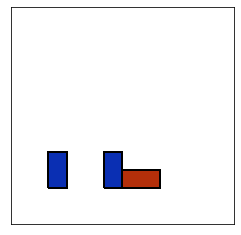

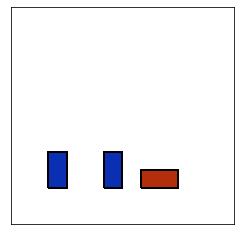

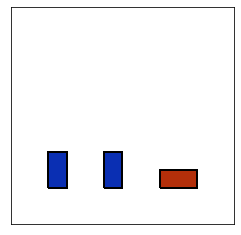

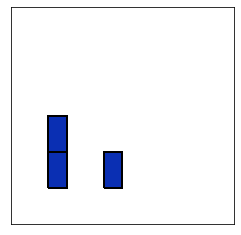

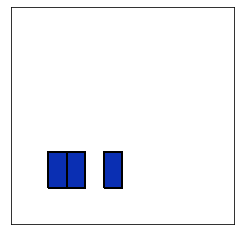

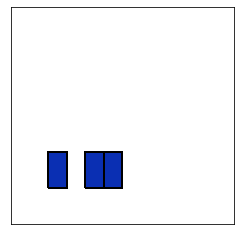

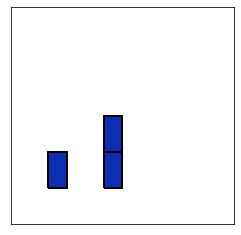

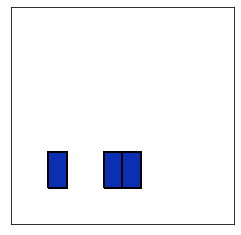

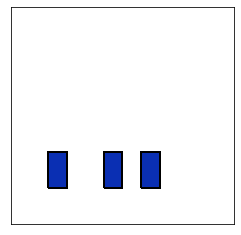

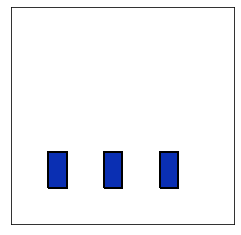

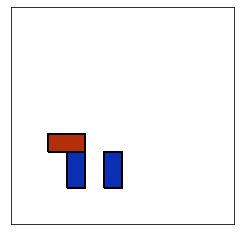

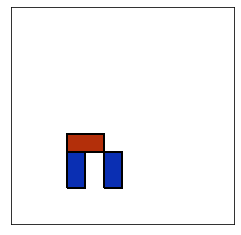

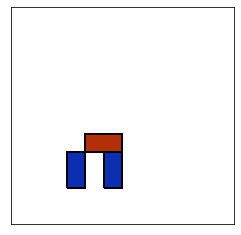

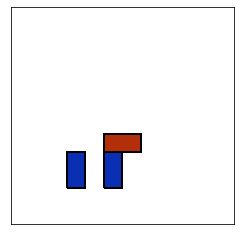

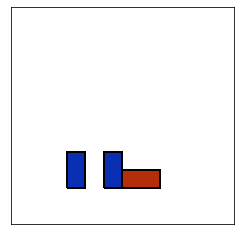

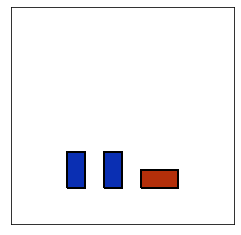

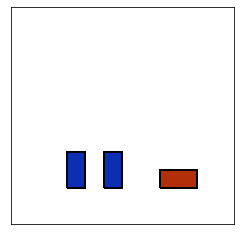

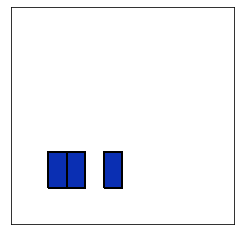

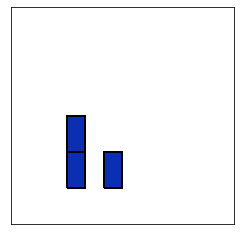

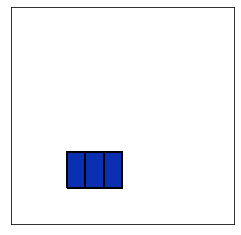

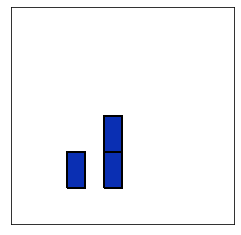

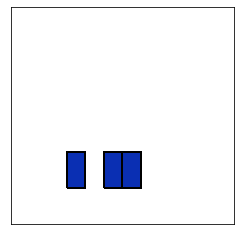

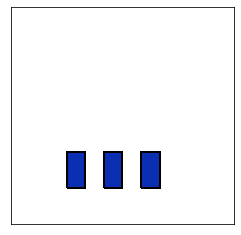

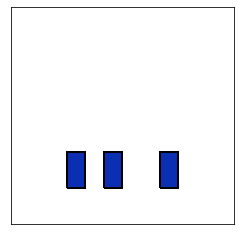

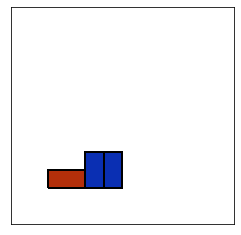

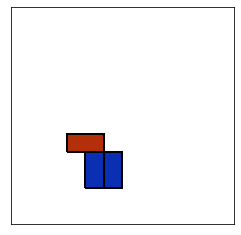

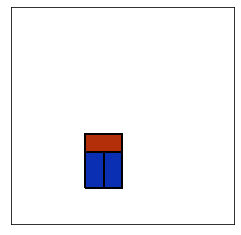

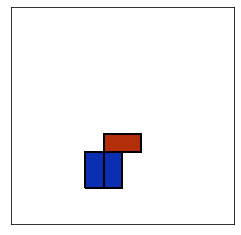

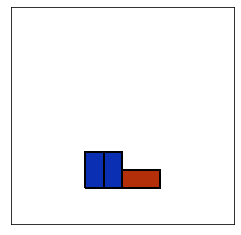

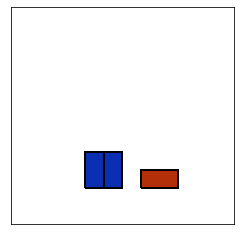

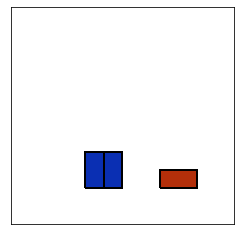

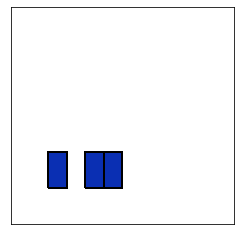

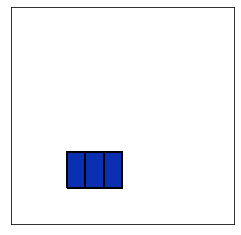

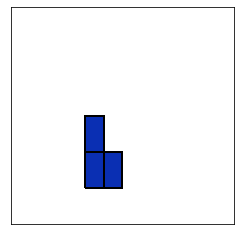

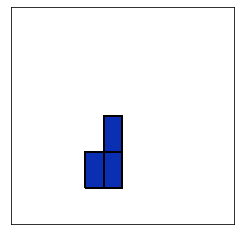

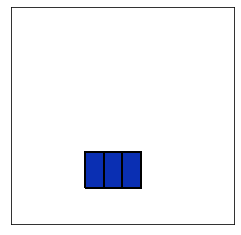

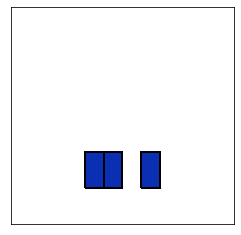

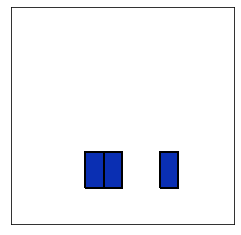

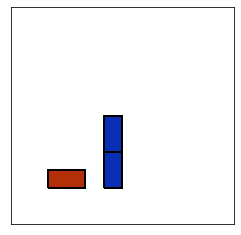

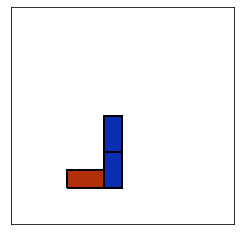

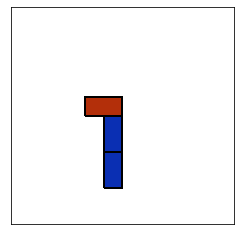

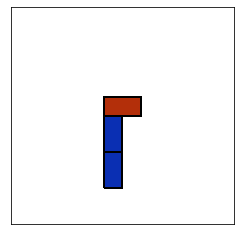

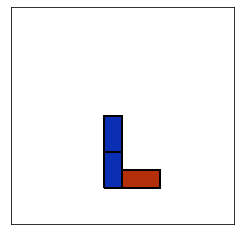

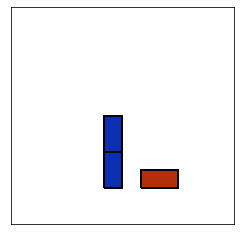

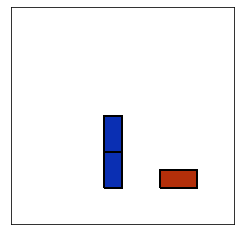

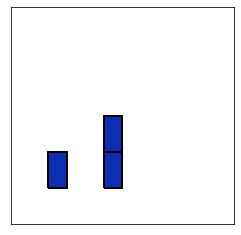

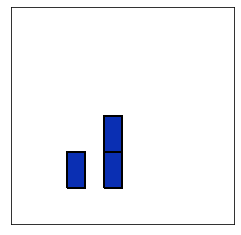

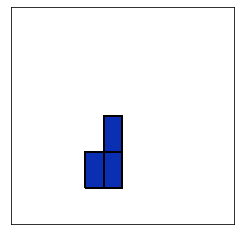

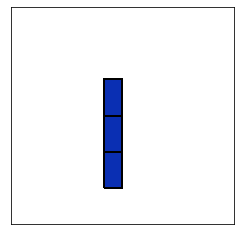

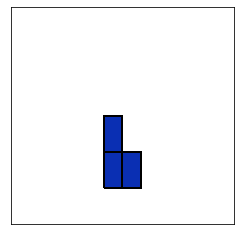

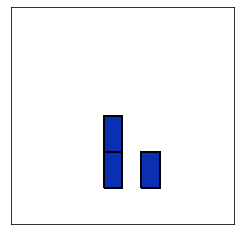

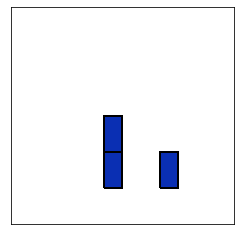

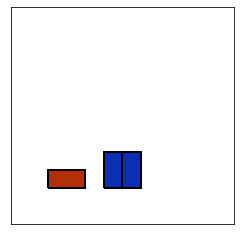

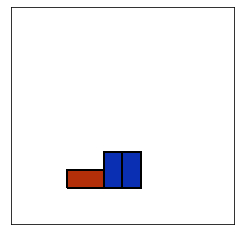

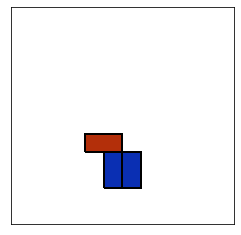

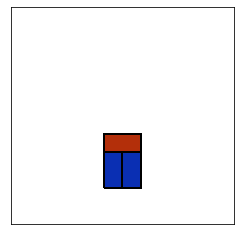

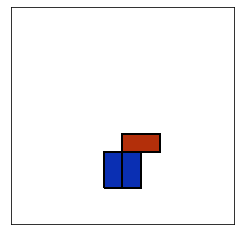

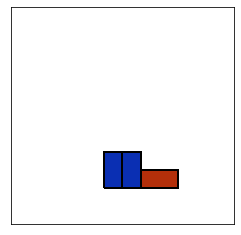

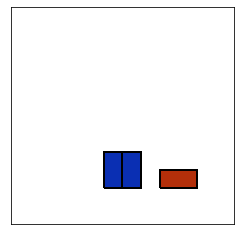

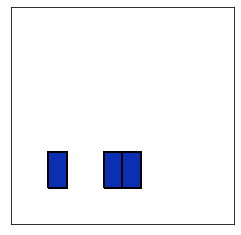

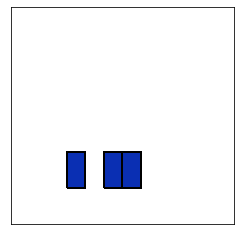

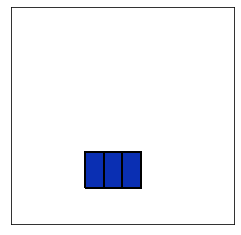

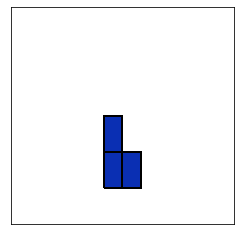

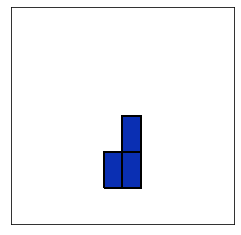

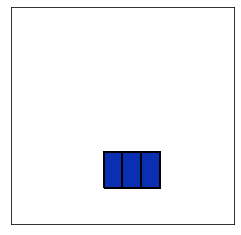

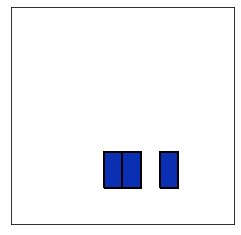

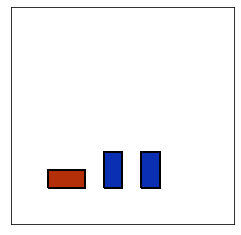

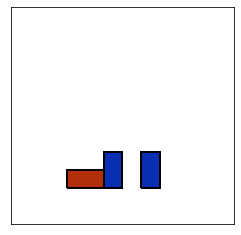

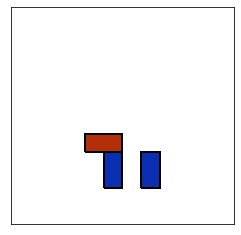

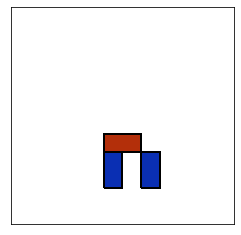

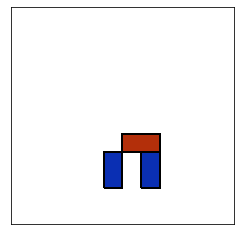

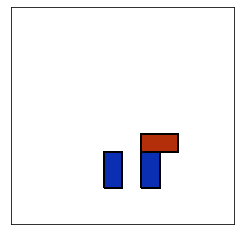

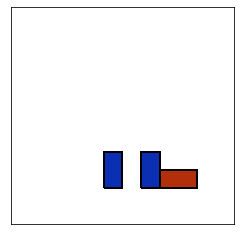

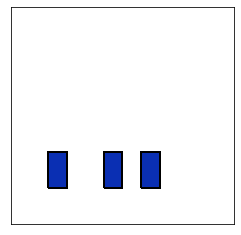

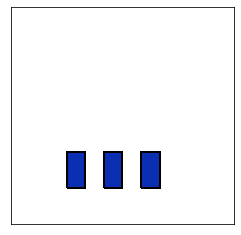

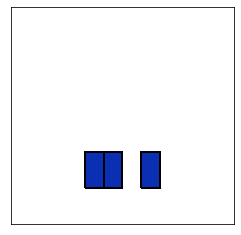

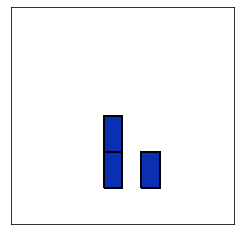

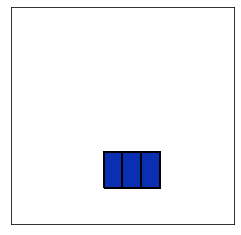

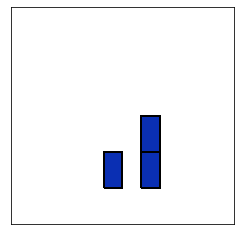

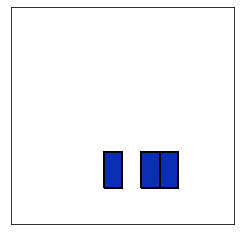

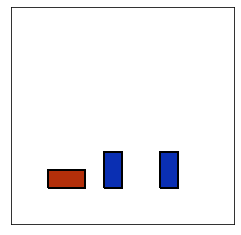

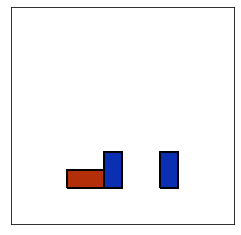

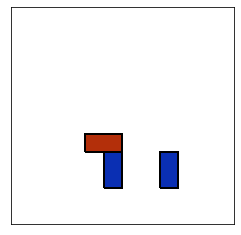

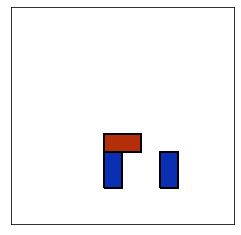

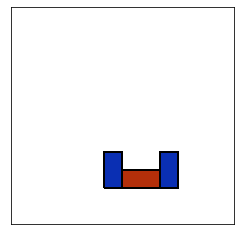

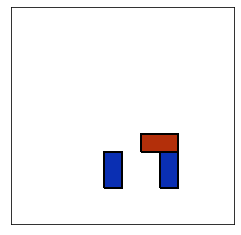

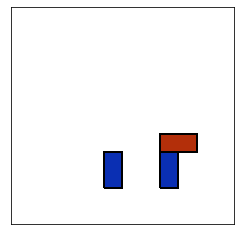

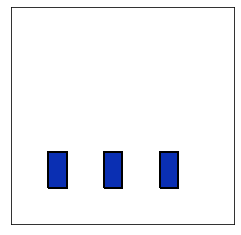

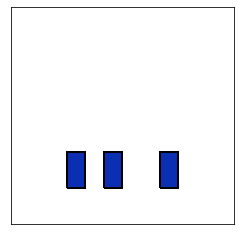

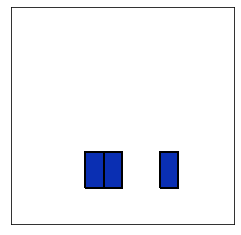

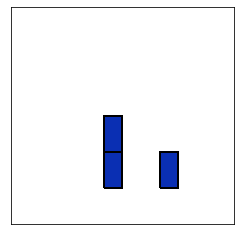

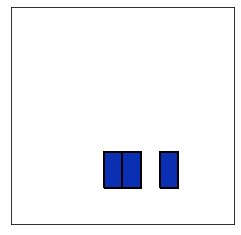

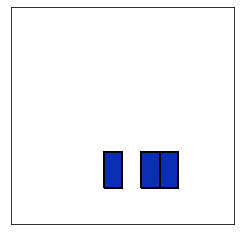

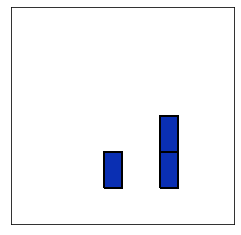

In [60]:
for blocks in stims[3]:
    w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
    w.populate_from_block_list(blocks)
    utils.draw_world(w)

In [73]:
len(stims[3])*2*7

5488

In [70]:
# four-block stims
stims[4] = []

# add block in position
for blocks in stims[3]:    
    for block in block_dims:
        for x in range(0, world_width-1):
            #repopulate world
            w = utils.World(block_dims = block_dims,
            block_colors = block_colors)
            w.populate_from_block_list(blocks)
    
            #add new block
            w.snap_to_floor(block[0], # width
                        block[1], # height
                        x)
            stims[4].append(w.get_block_dict()['blocks'])


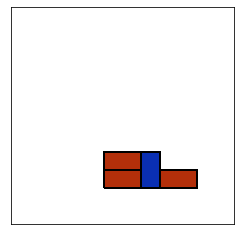

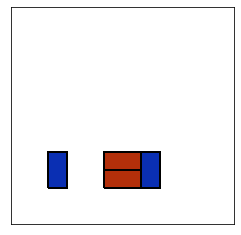

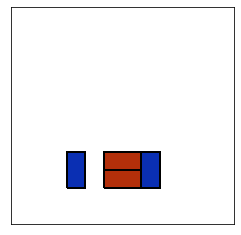

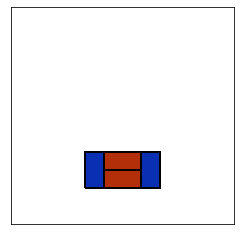

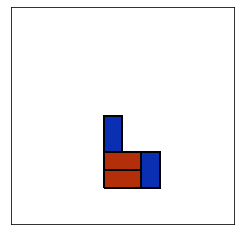

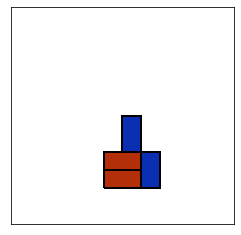

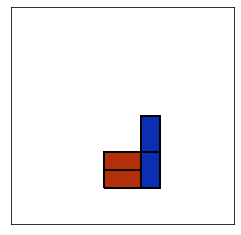

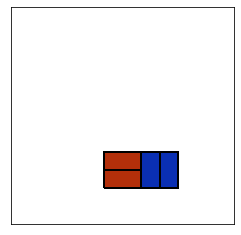

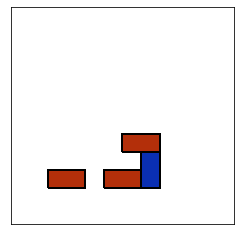

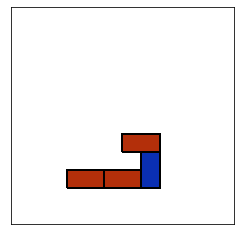

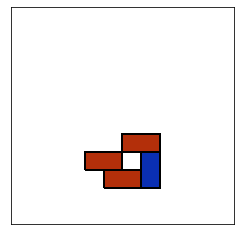

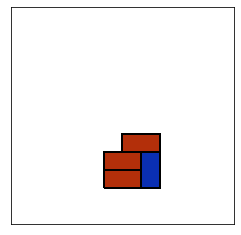

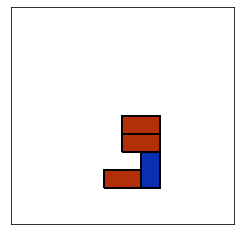

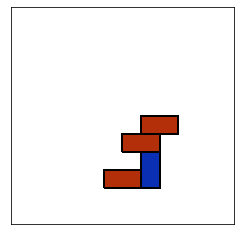

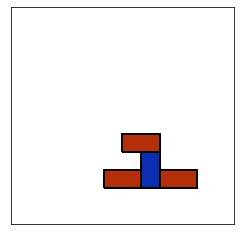

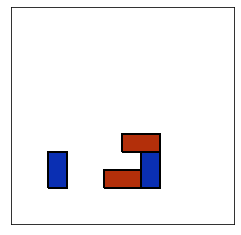

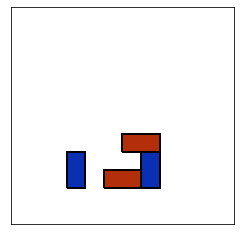

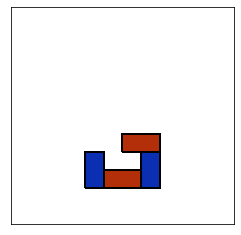

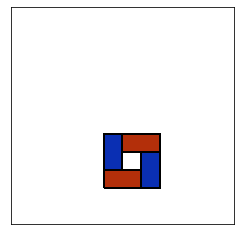

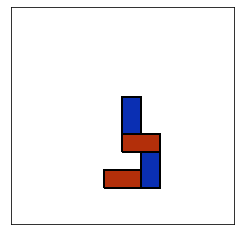

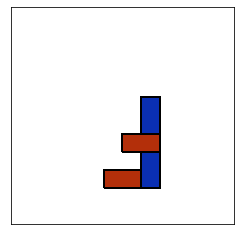

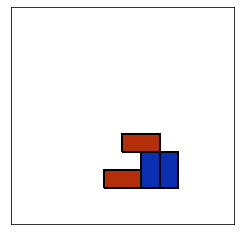

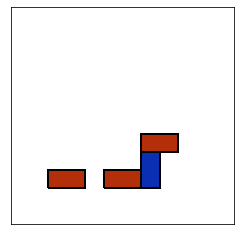

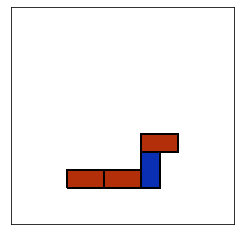

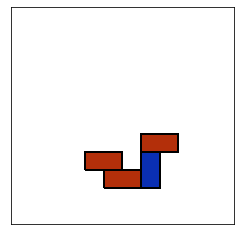

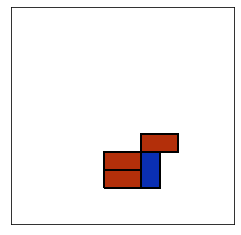

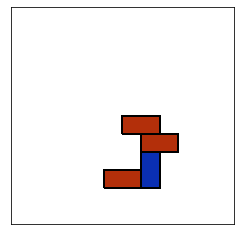

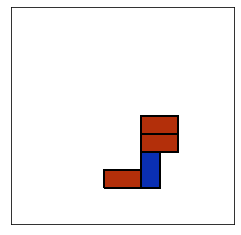

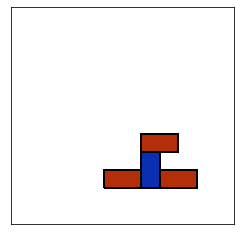

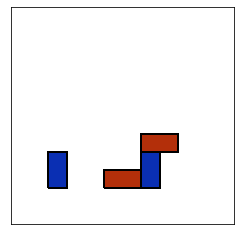

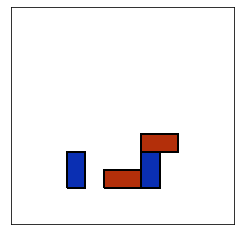

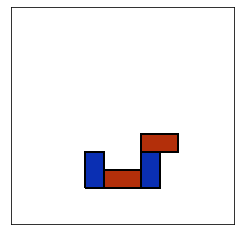

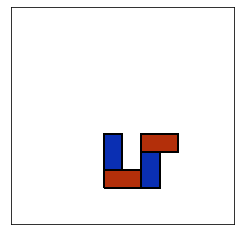

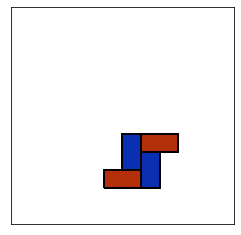

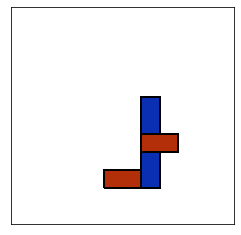

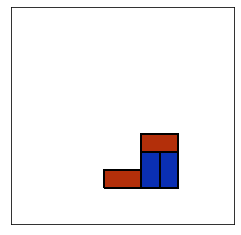

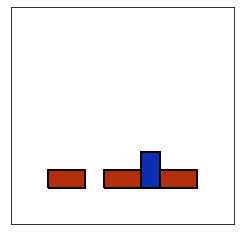

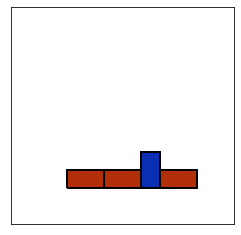

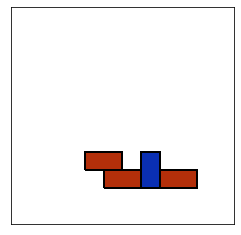

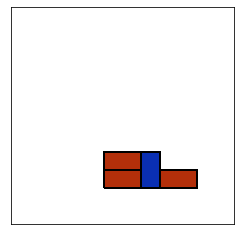

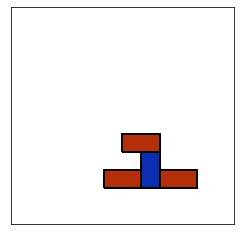

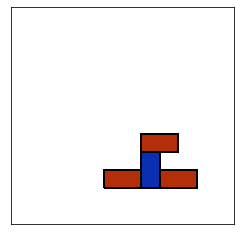

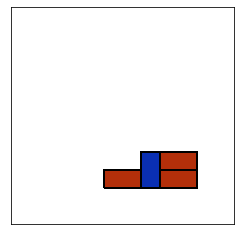

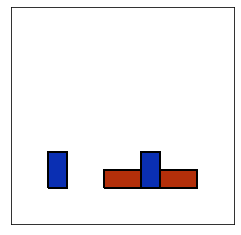

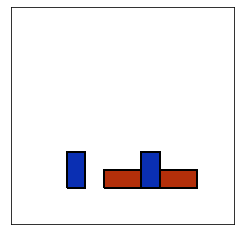

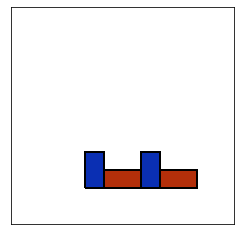

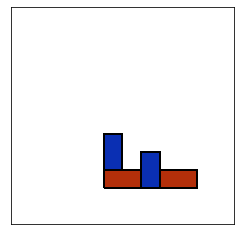

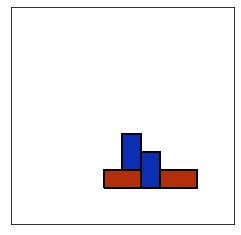

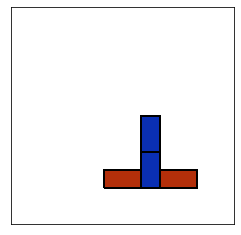

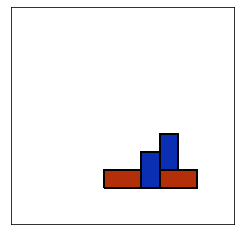

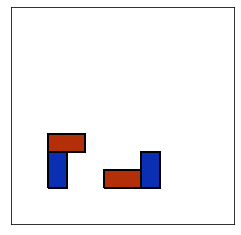

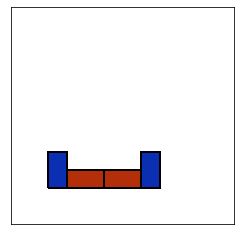

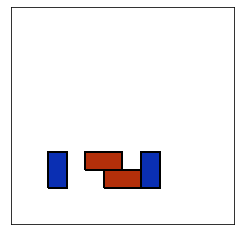

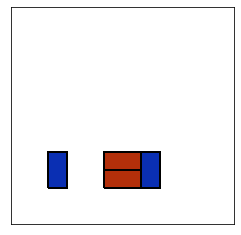

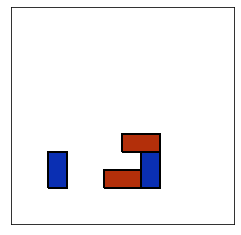

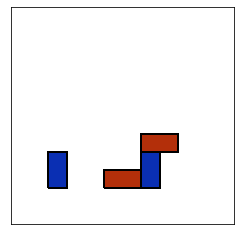

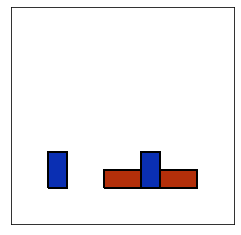

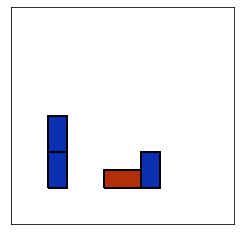

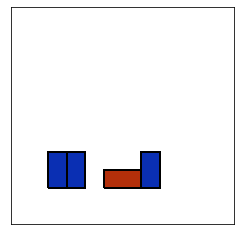

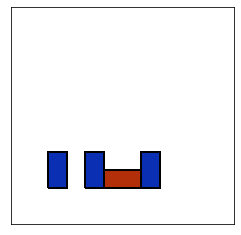

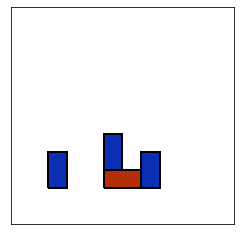

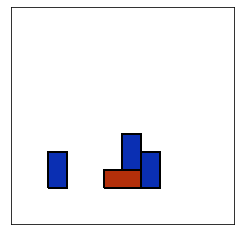

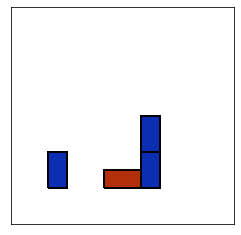

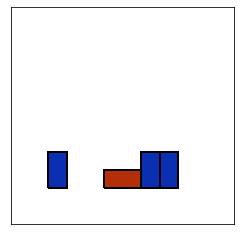

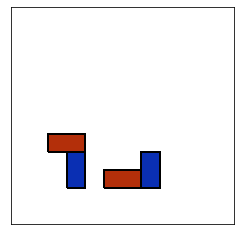

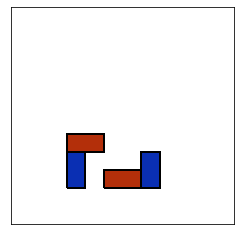

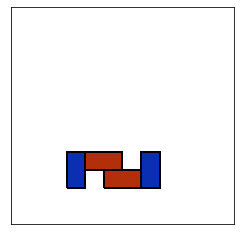

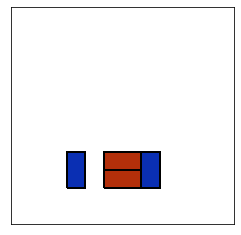

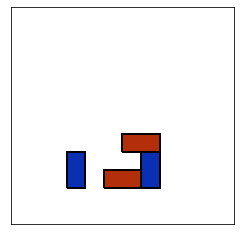

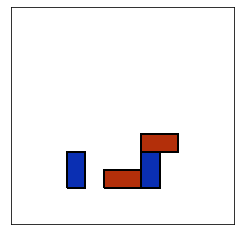

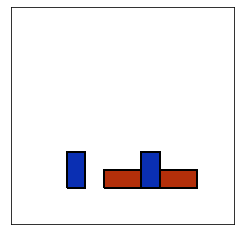

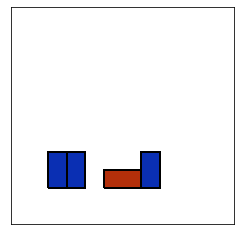

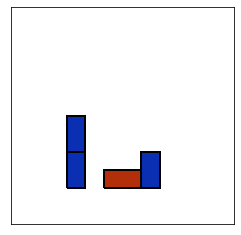

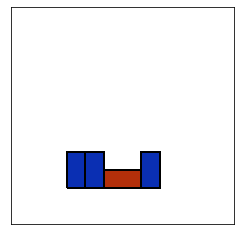

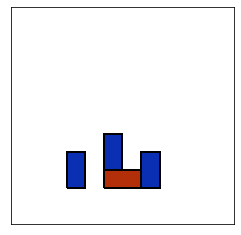

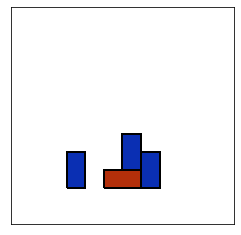

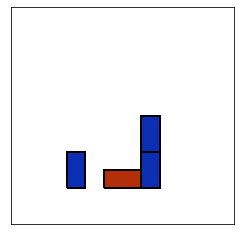

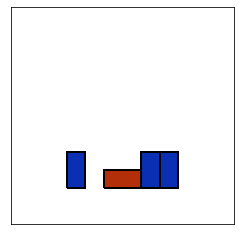

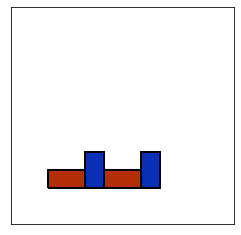

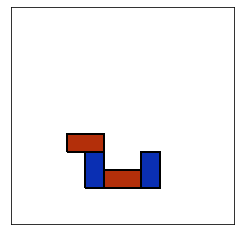

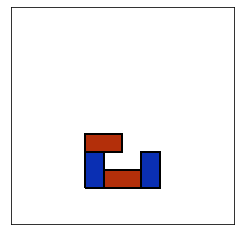

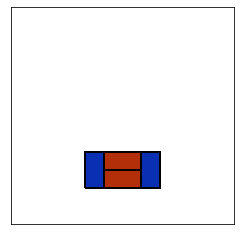

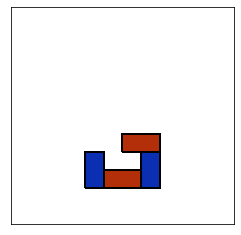

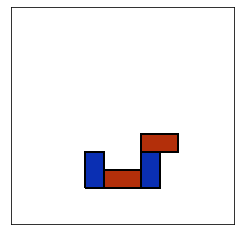

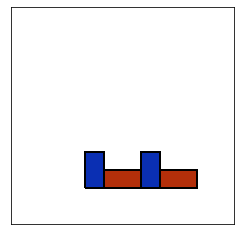

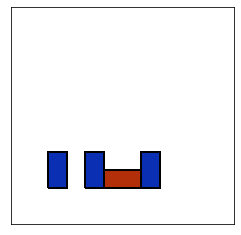

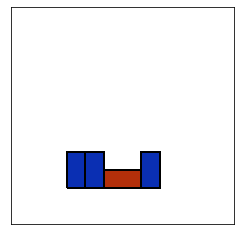

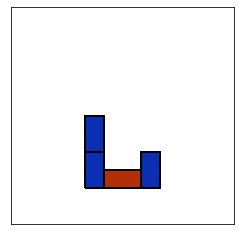

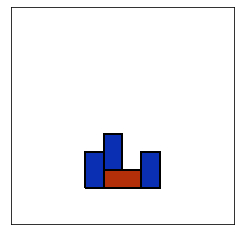

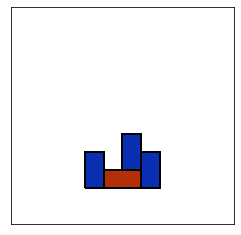

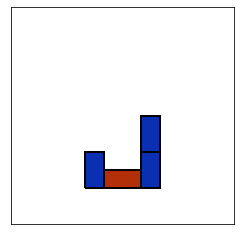

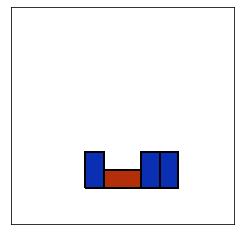

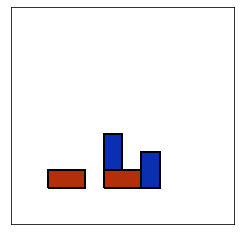

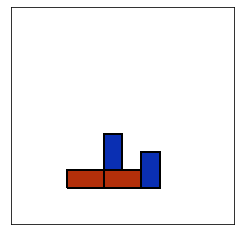

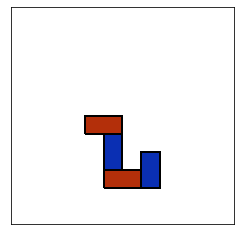

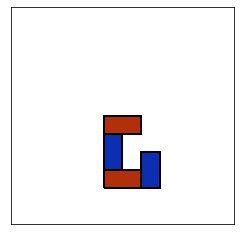

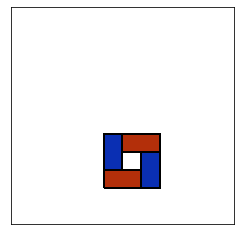

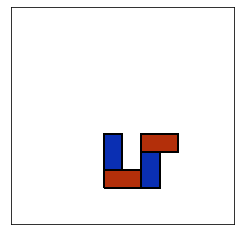

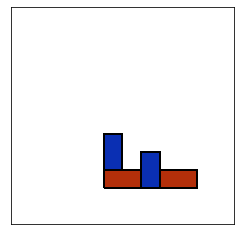

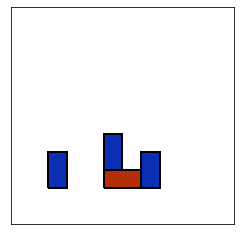

In [78]:
for blocks in stims[4][2400:2500]:
    w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
    w.populate_from_block_list(blocks)
    utils.draw_world(w)

In [89]:
# how many of each? (not necessarily unique)
_ = [print(len(stims[i])) for i in stims.keys()]

2
28
392
5488


In [90]:
# all towers with 4 blocks (not unique)
stims[4]

[[{'x': 3, 'y': 0, 'height': 1, 'width': 2},
  {'x': 0, 'y': 0, 'height': 1, 'width': 2},
  {'x': 0, 'y': 1, 'height': 1, 'width': 2},
  {'x': 0, 'y': 2, 'height': 1, 'width': 2}],
 [{'x': 3, 'y': 0, 'height': 1, 'width': 2},
  {'x': 0, 'y': 0, 'height': 1, 'width': 2},
  {'x': 0, 'y': 1, 'height': 1, 'width': 2},
  {'x': 1, 'y': 2, 'height': 1, 'width': 2}],
 [{'x': 3, 'y': 0, 'height': 1, 'width': 2},
  {'x': 0, 'y': 0, 'height': 1, 'width': 2},
  {'x': 0, 'y': 1, 'height': 1, 'width': 2},
  {'x': 2, 'y': 1, 'height': 1, 'width': 2}],
 [{'x': 3, 'y': 0, 'height': 1, 'width': 2},
  {'x': 0, 'y': 0, 'height': 1, 'width': 2},
  {'x': 0, 'y': 1, 'height': 1, 'width': 2},
  {'x': 3, 'y': 1, 'height': 1, 'width': 2}],
 [{'x': 3, 'y': 0, 'height': 1, 'width': 2},
  {'x': 0, 'y': 0, 'height': 1, 'width': 2},
  {'x': 0, 'y': 1, 'height': 1, 'width': 2},
  {'x': 4, 'y': 1, 'height': 1, 'width': 2}],
 [{'x': 3, 'y': 0, 'height': 1, 'width': 2},
  {'x': 0, 'y': 0, 'height': 1, 'width': 2},
  {'x

In [97]:
# sort the blocks within a tower to find unique towers
stims_sorted_blocks = [sorted(tower, key = lambda block: (block['x'],block['y'],block['height'],block['width'])) 
     for tower in stims[4]]

In [124]:
# convert dictionary representations of towers to (hashable) tuple and back

def world_dicts_to_tuples(wd):
    wt = tuple((block['x'],block['y'],block['height'],block['width']) for block in wd)
    return wt

def world_tuples_to_dicts(wt):
    wd = [{'x': block[0],
             'y': block[1],
             'height': block[2],
             'width': block[3]} for block in wt]
    return wd

In [178]:
tower_tuples = [world_dicts_to_tuples(tower) for tower in stims_sorted_blocks]
print(str(len(tower_tuples)) + ' towers of 4 blocks')


unique_towers_tuples = set(tower_tuples)
print(str(len(unique_towers_tuples)) + ' unique towers of 4 blocks')


5488 towers of 4 blocks
1650 unique towers of 4 blocks


In [133]:
# all unique towers with 4 blocks (not contiguous)
unique_towers_dicts = [world_tuples_to_dicts(tower) for tower in unique_towers_tuples]

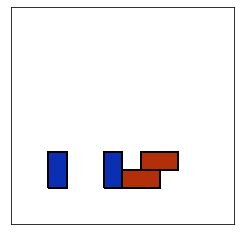

In [199]:
w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
w.populate_from_block_list(unique_towers_dicts[0])
utils.draw_world(w)

In [193]:
# Filter non-connected towers

# connectivity: 1 for just orthogonal, 2, for diagonal as well
connected_towers = [tower for tower in unique_towers_dicts\
                        if utils.worldify(tower).fully_connected(connectivity=1)]



In [194]:
print(str(len(connected_towers)) + ' unique connected towers of 4 blocks')

706 unique connected towers of 4 blocks


### other filters

- at least 1 or 2 blocks off ground
- 2 horizontal, 2 vertical
- height
- max width




In [250]:
# Filter towers based on how many blocks are off ground level

min_blocks_supported = 1

towers_with_n_blocks_supported = [tower for tower in connected_towers \
                                  if utils.worldify(tower).blocks_above_ground(min_blocks_supported)]

print(str(len(towers_with_n_blocks_supported)) + ' towers with ' + str(min_blocks_supported) + ' or more blocks above ground-level')

678 towers with 1 or more blocks above ground-level


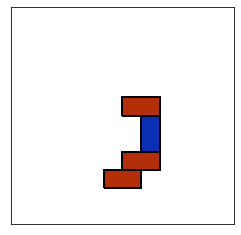

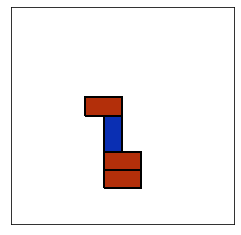

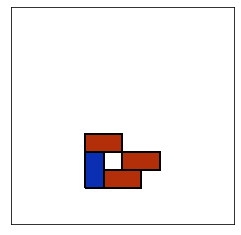

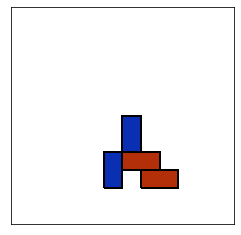

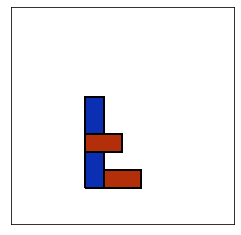

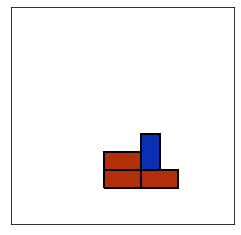

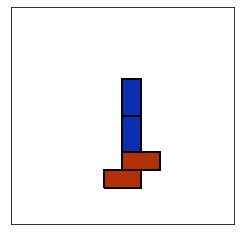

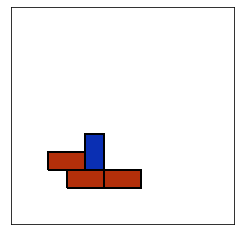

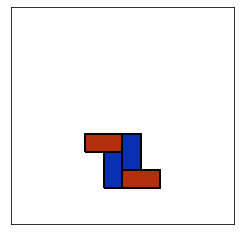

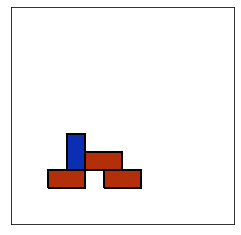

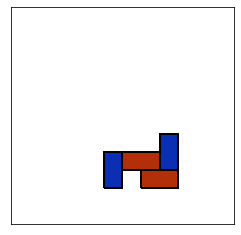

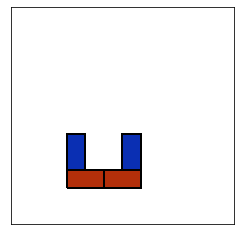

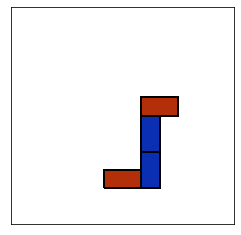

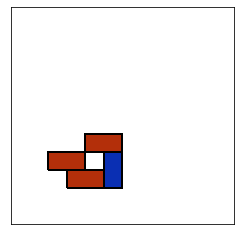

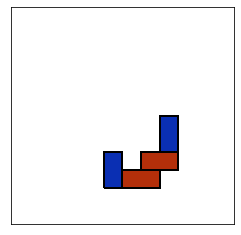

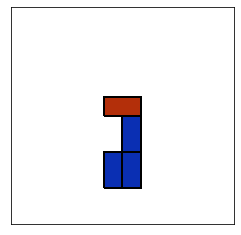

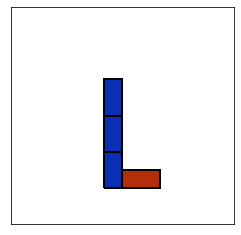

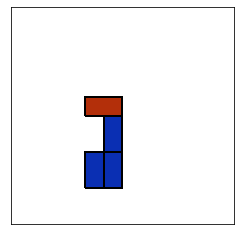

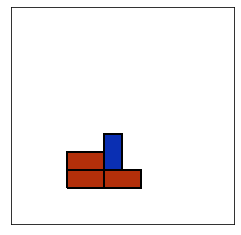

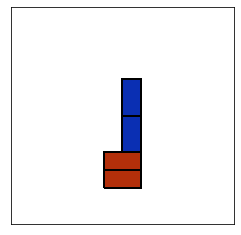

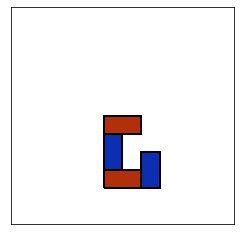

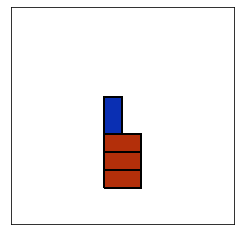

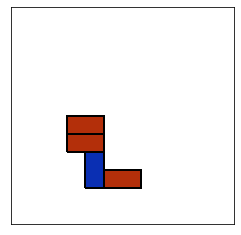

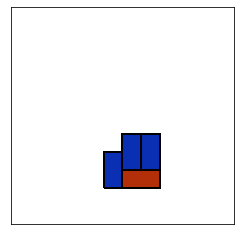

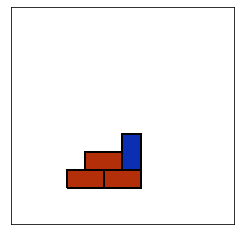

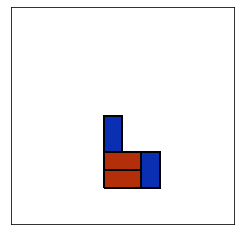

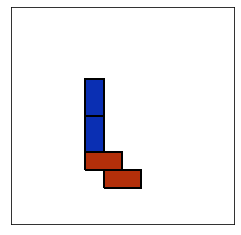

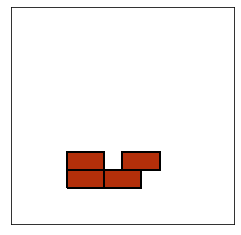

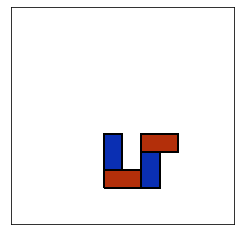

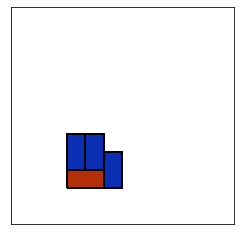

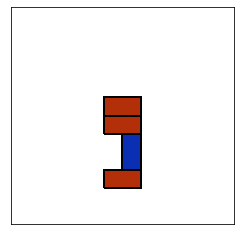

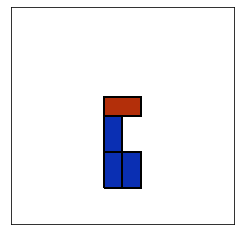

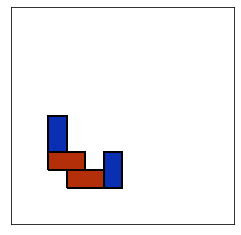

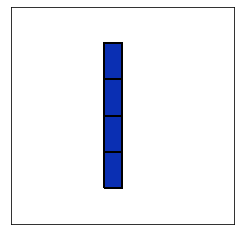

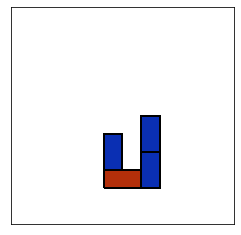

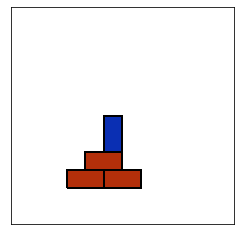

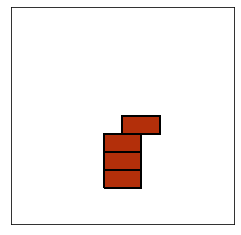

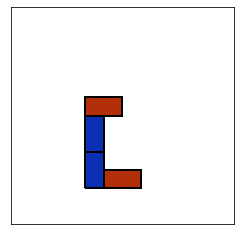

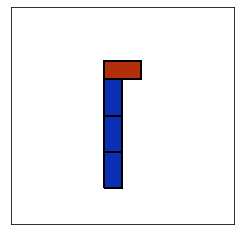

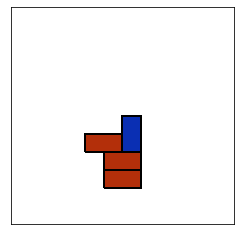

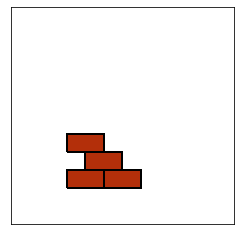

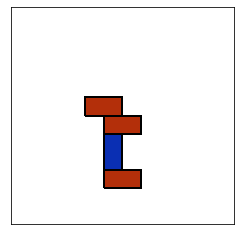

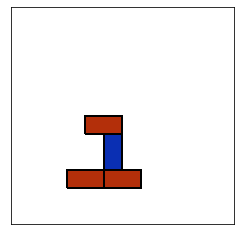

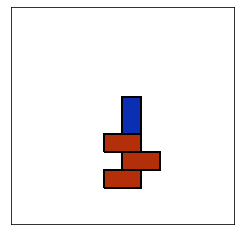

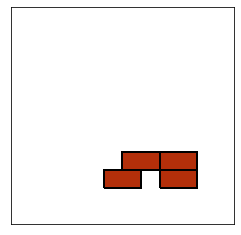

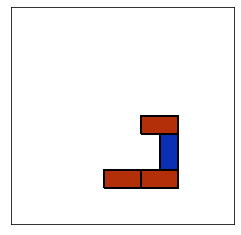

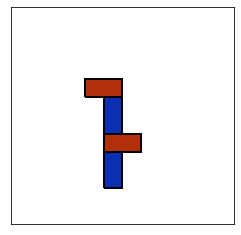

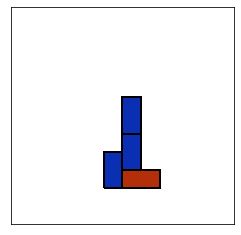

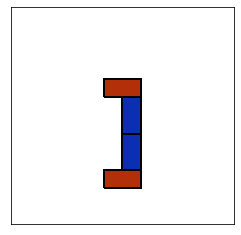

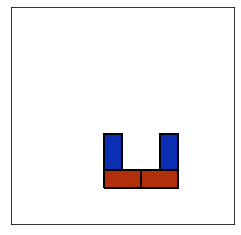

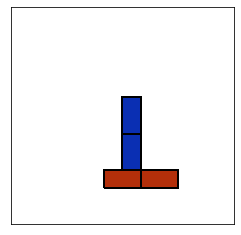

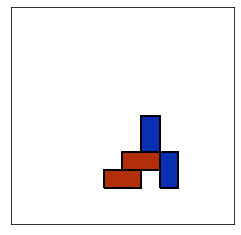

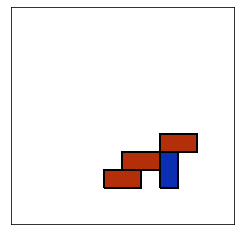

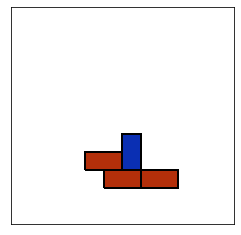

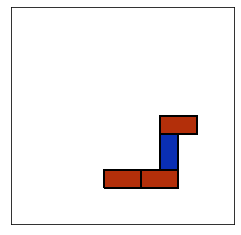

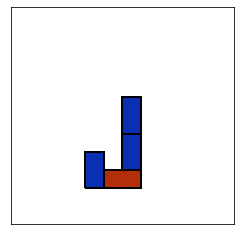

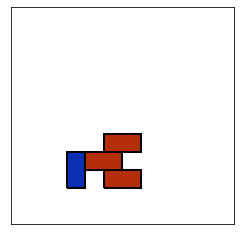

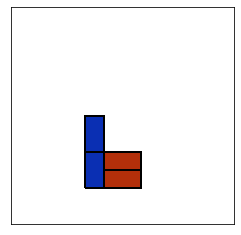

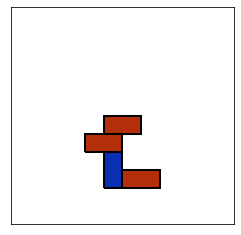

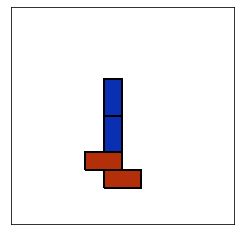

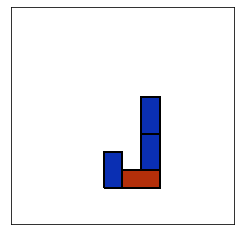

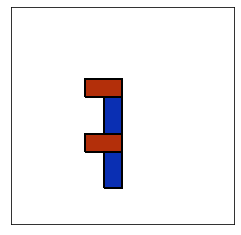

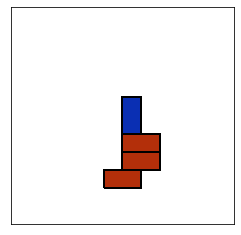

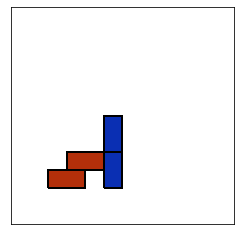

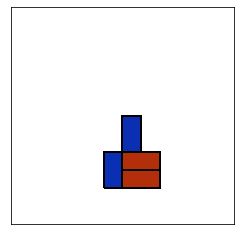

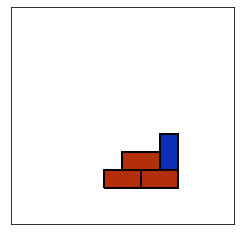

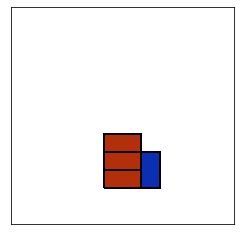

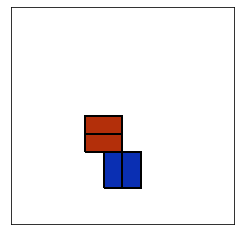

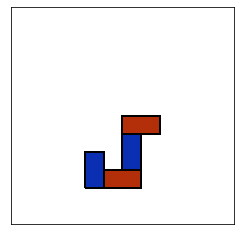

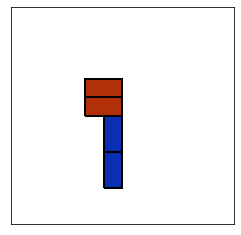

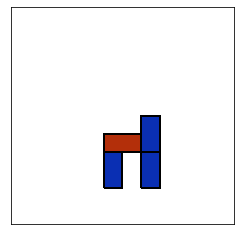

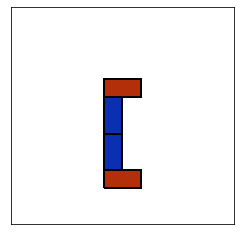

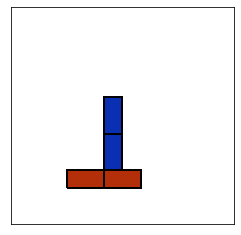

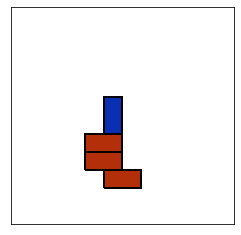

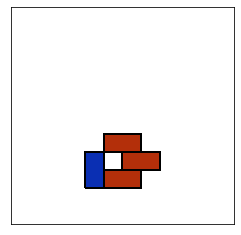

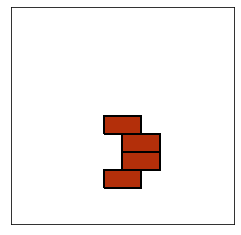

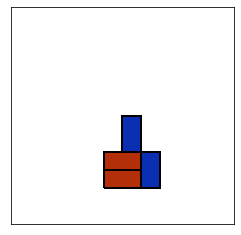

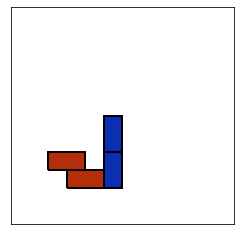

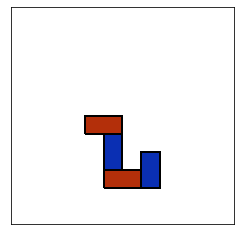

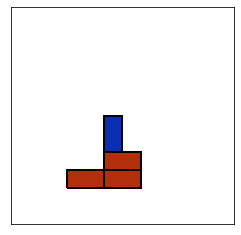

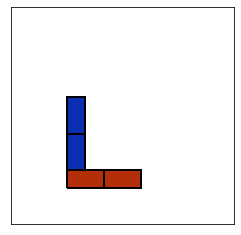

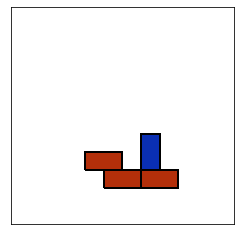

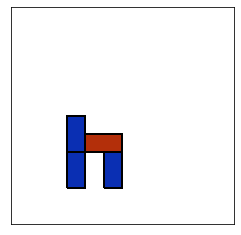

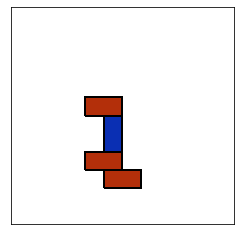

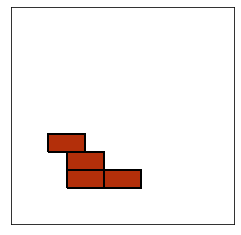

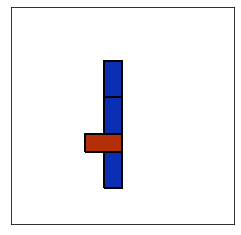

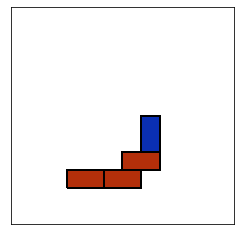

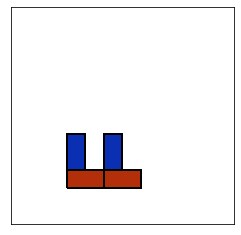

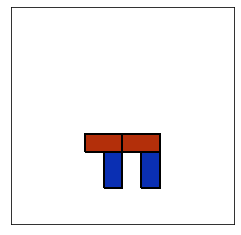

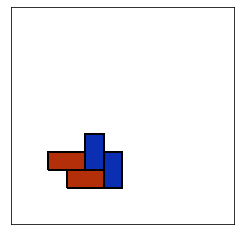

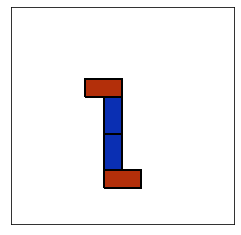

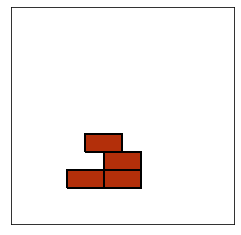

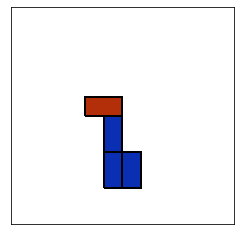

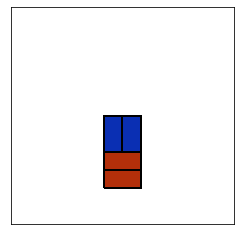

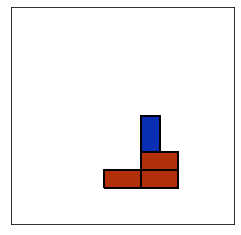

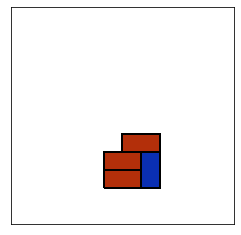

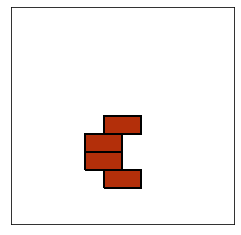

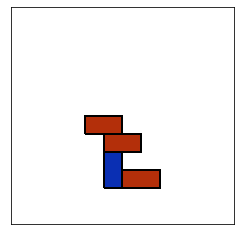

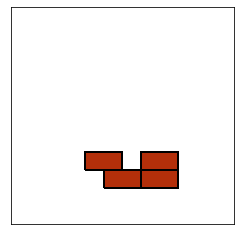

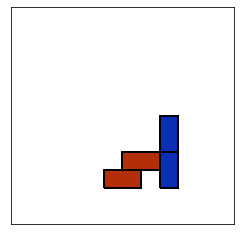

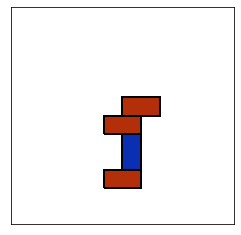

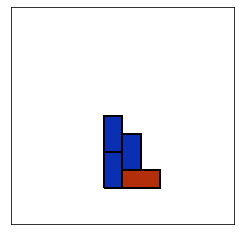

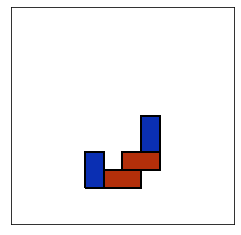

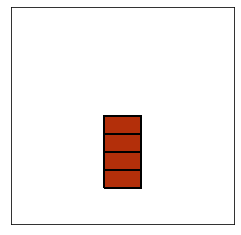

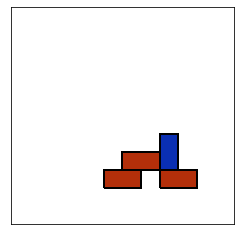

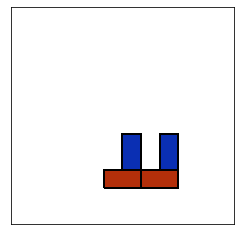

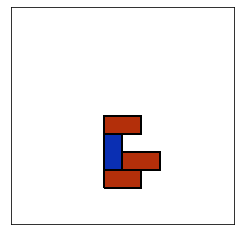

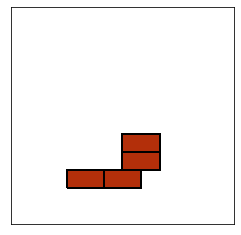

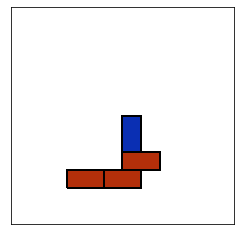

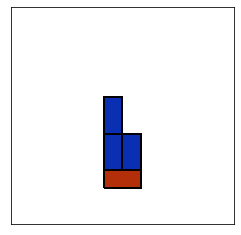

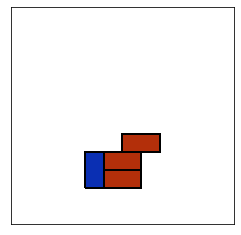

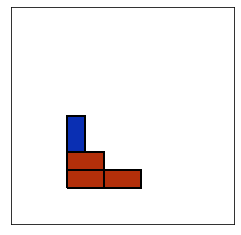

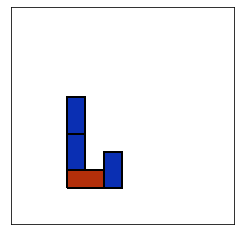

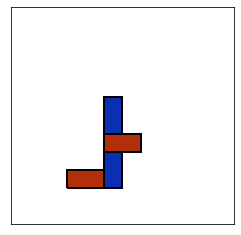

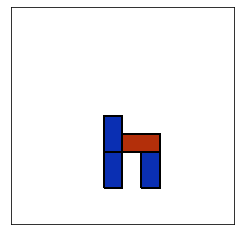

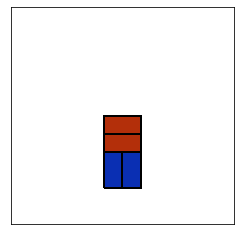

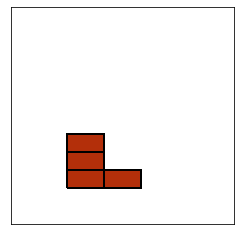

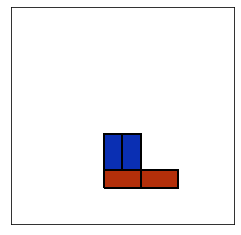

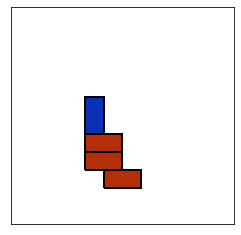

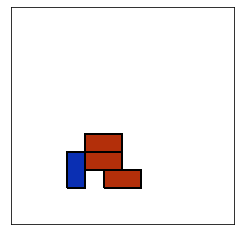

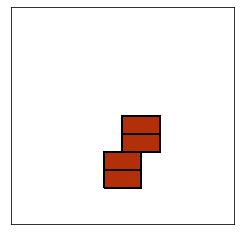

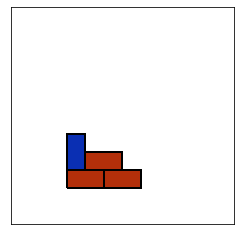

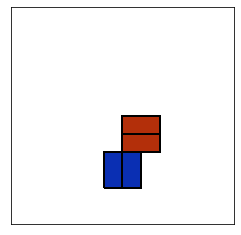

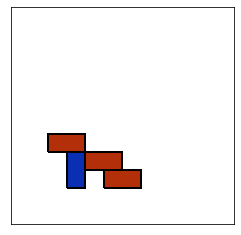

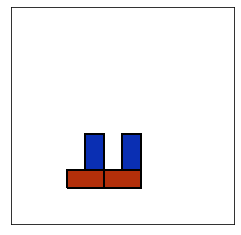

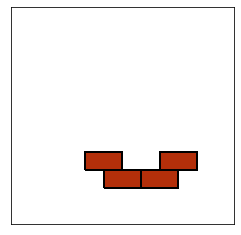

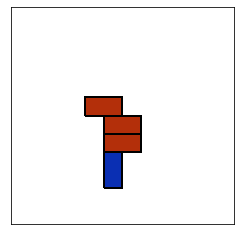

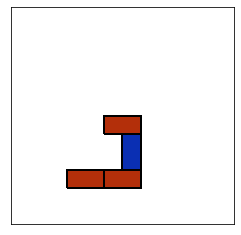

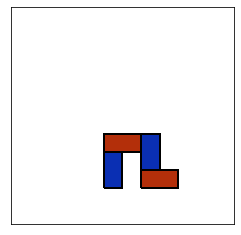

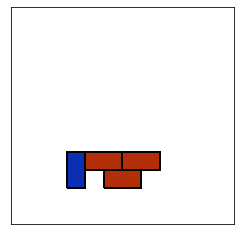

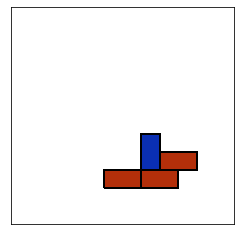

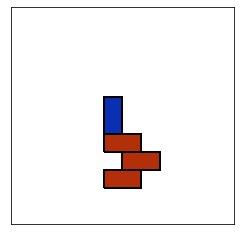

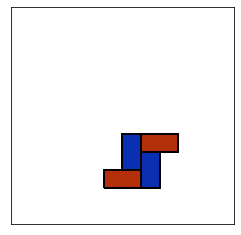

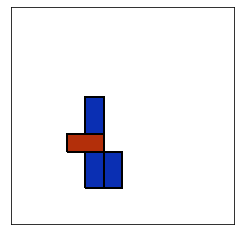

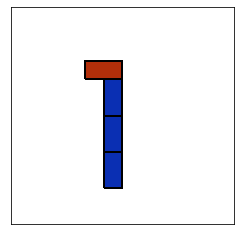

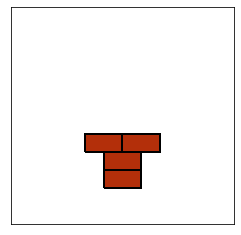

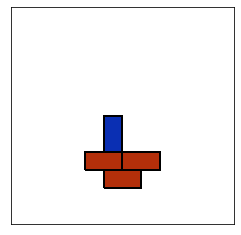

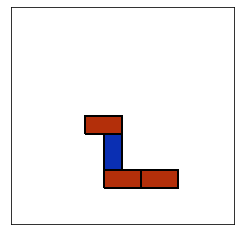

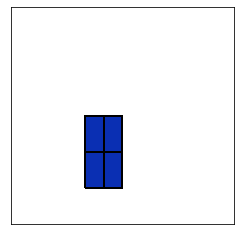

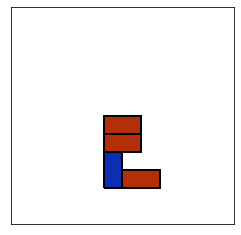

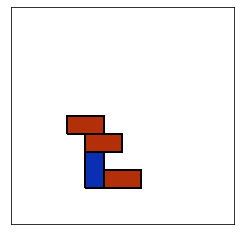

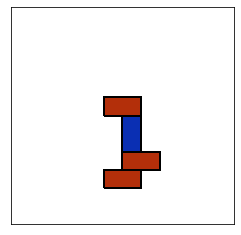

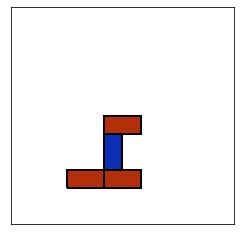

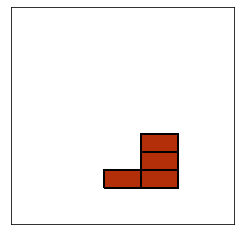

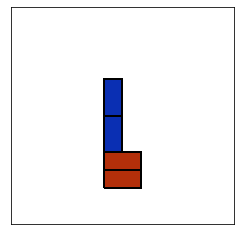

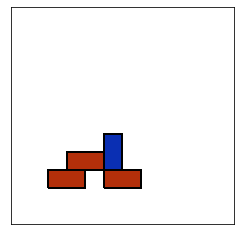

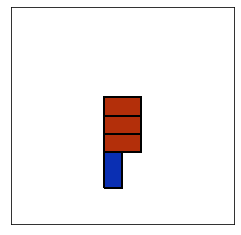

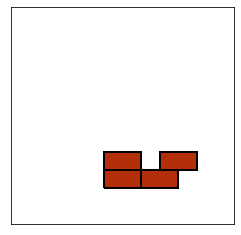

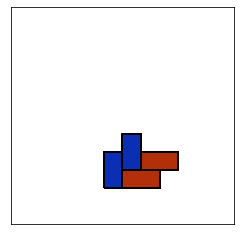

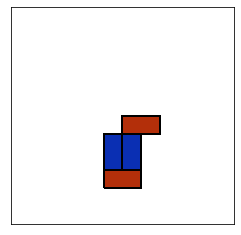

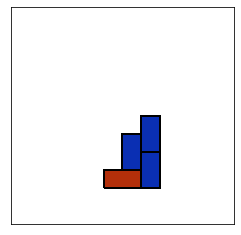

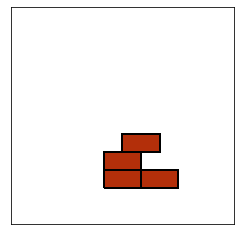

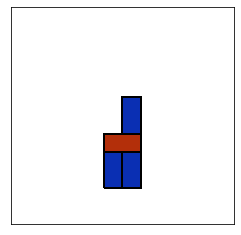

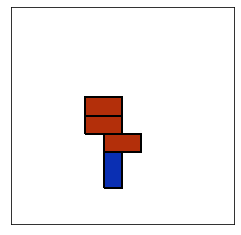

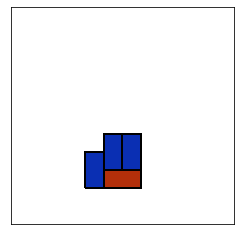

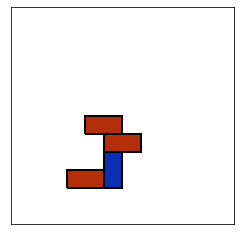

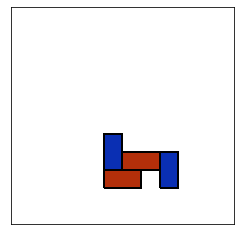

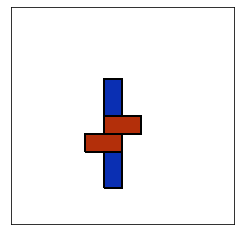

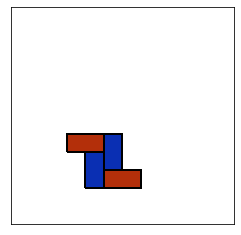

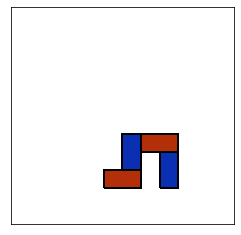

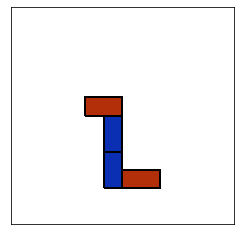

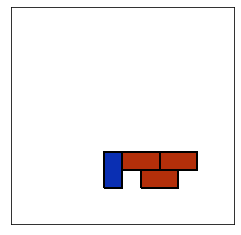

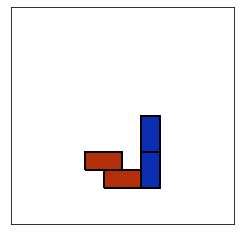

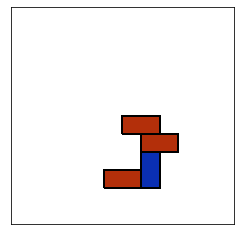

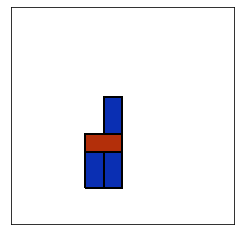

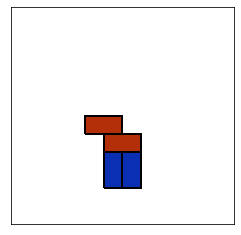

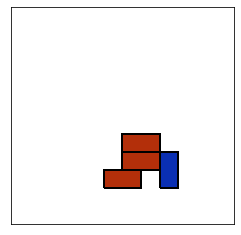

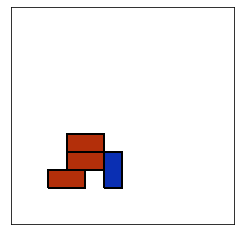

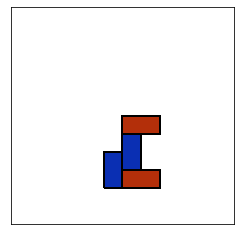

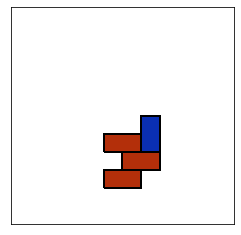

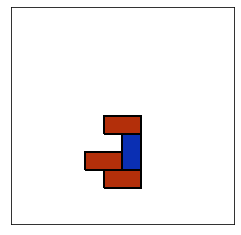

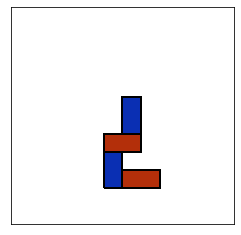

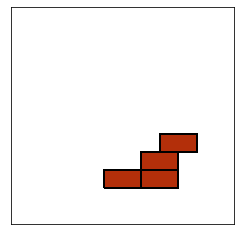

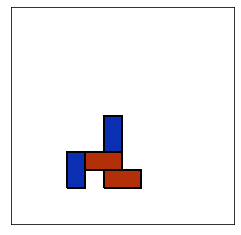

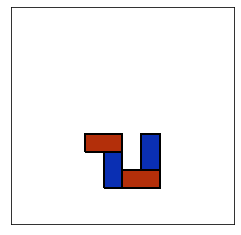

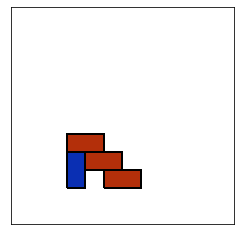

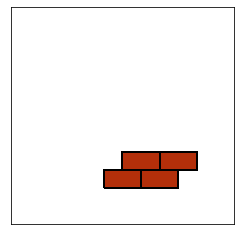

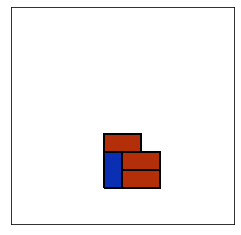

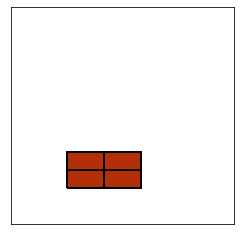

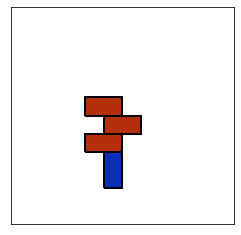

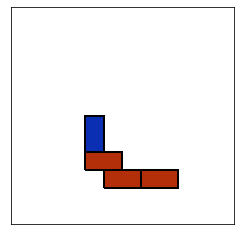

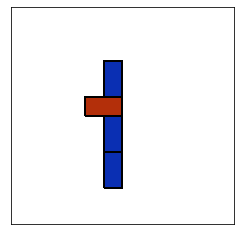

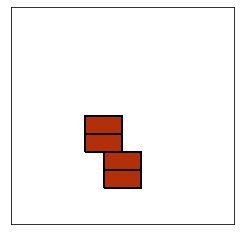

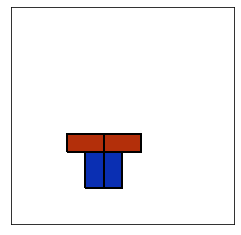

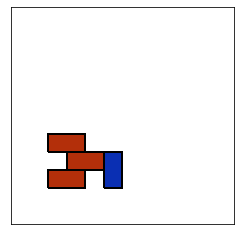

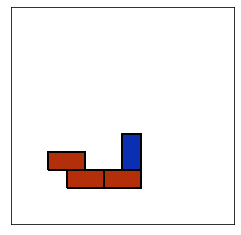

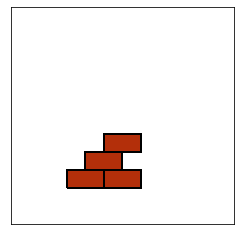

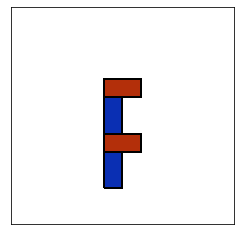

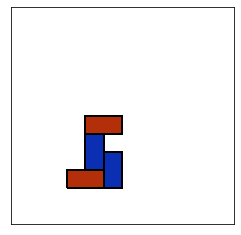

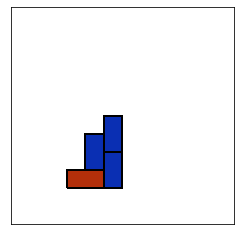

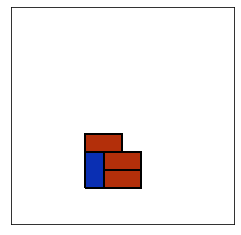

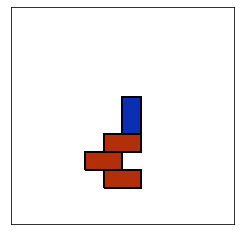

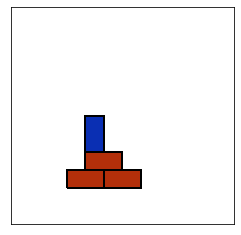

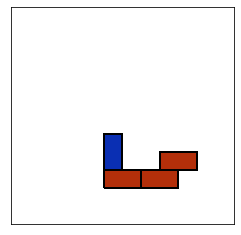

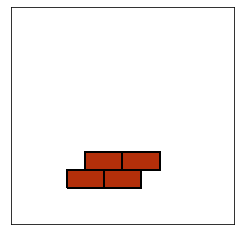

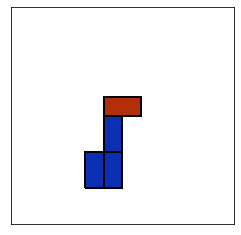

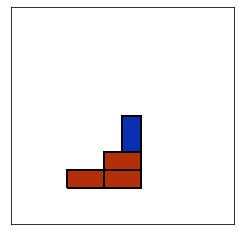

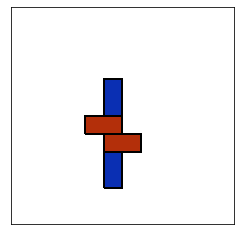

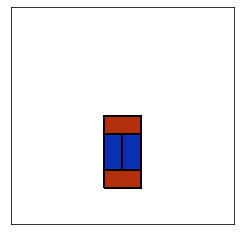

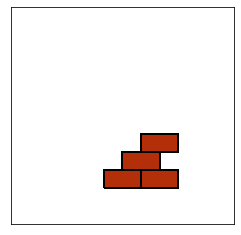

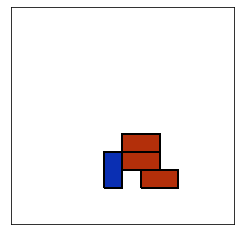

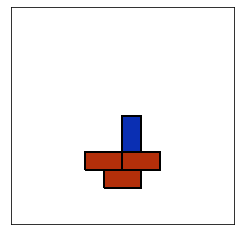

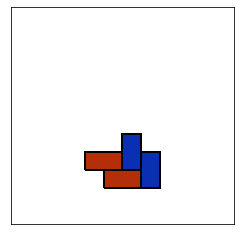

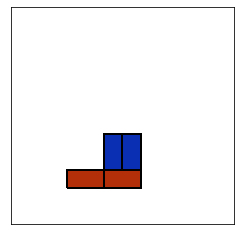

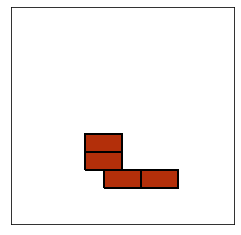

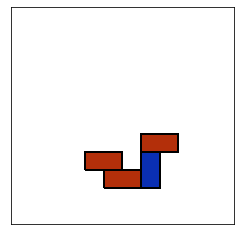

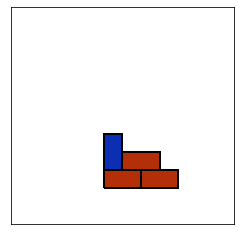

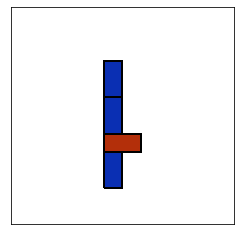

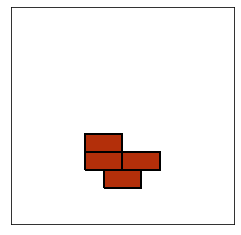

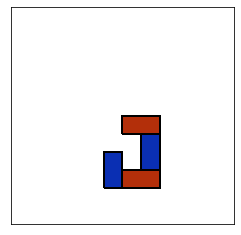

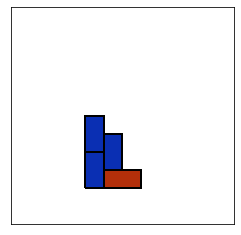

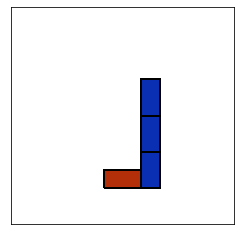

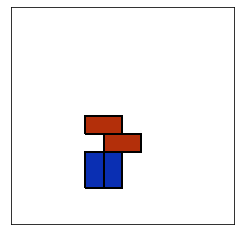

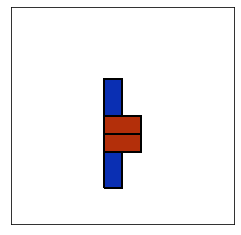

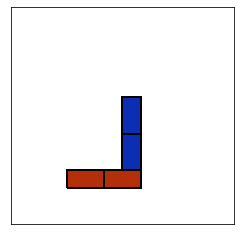

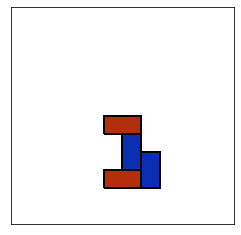

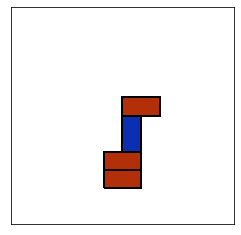

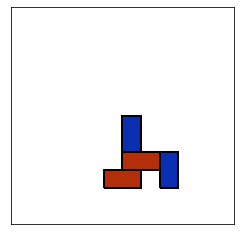

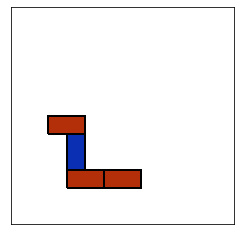

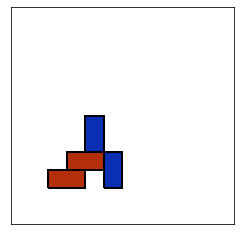

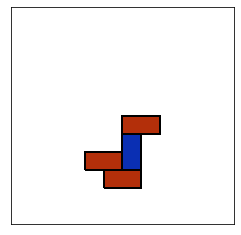

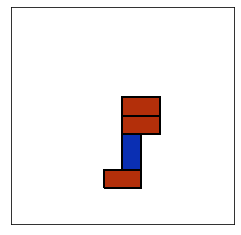

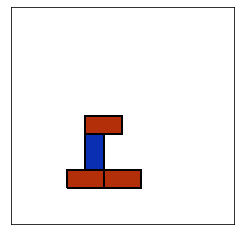

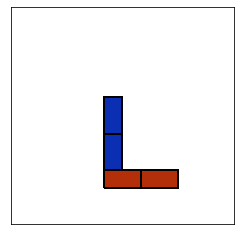

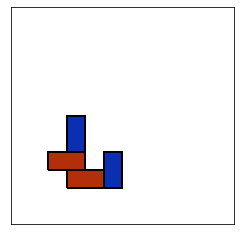

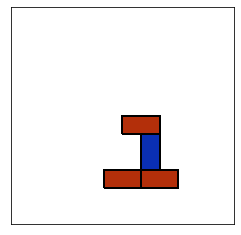

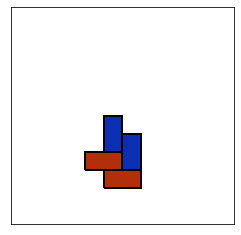

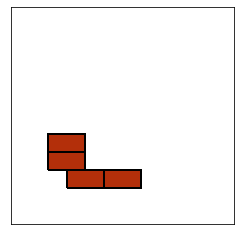

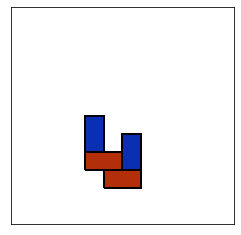

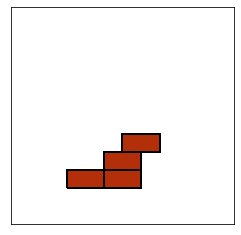

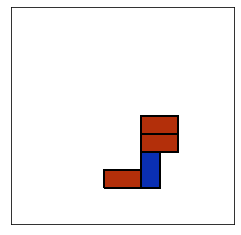

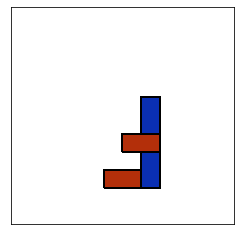

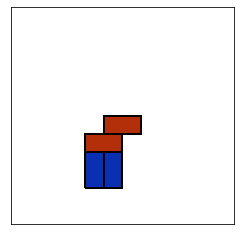

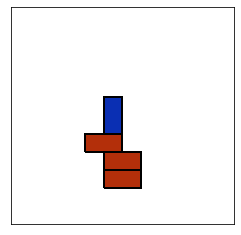

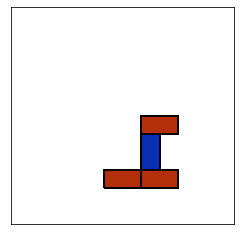

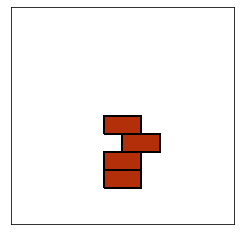

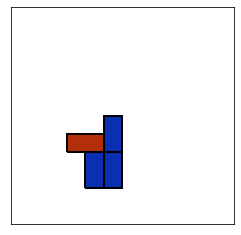

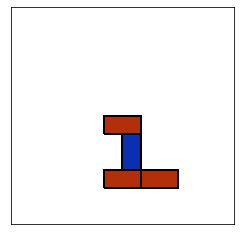

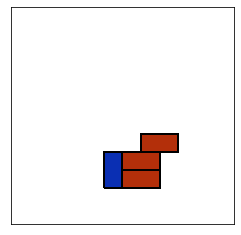

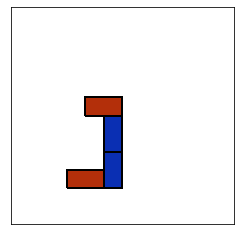

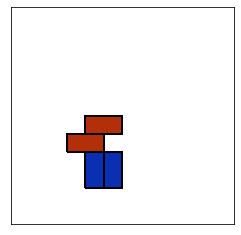

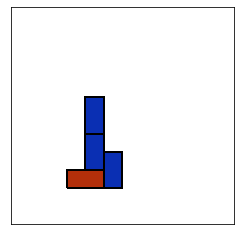

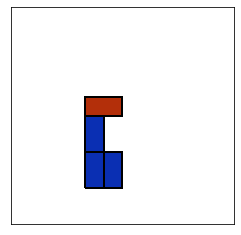

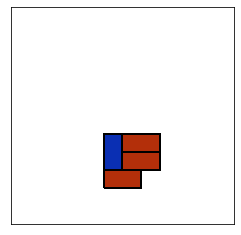

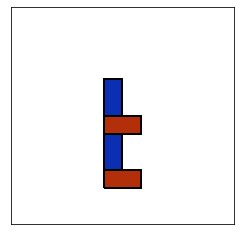

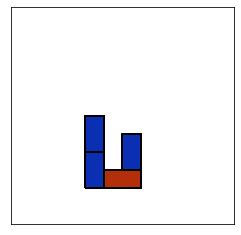

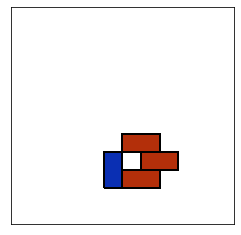

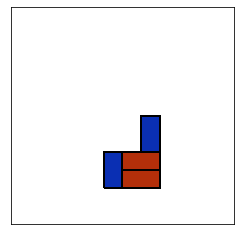

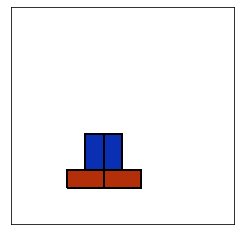

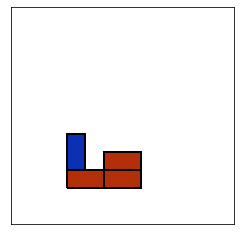

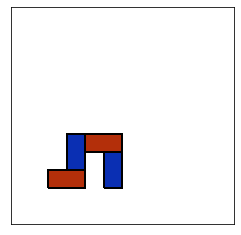

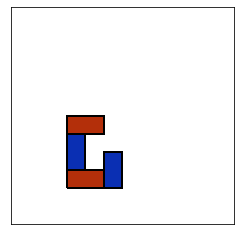

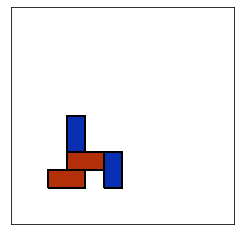

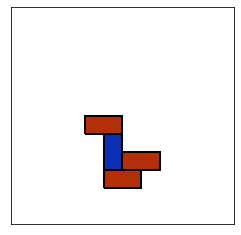

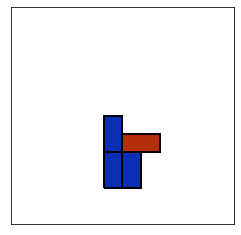

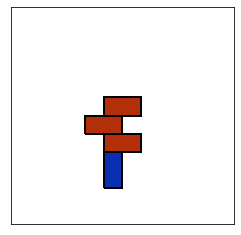

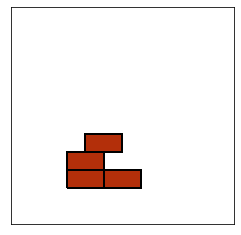

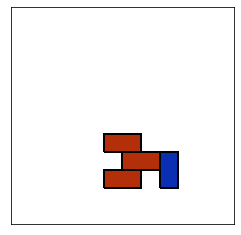

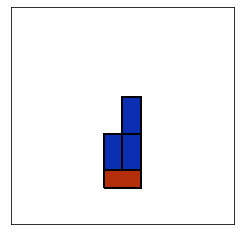

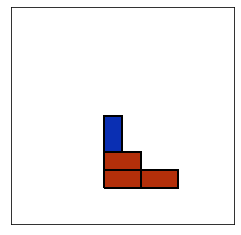

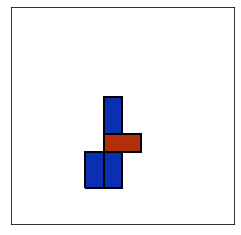

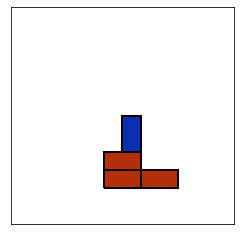

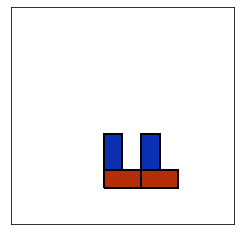

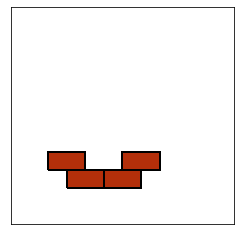

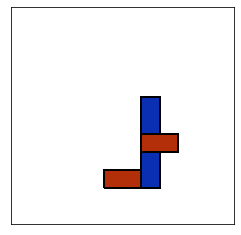

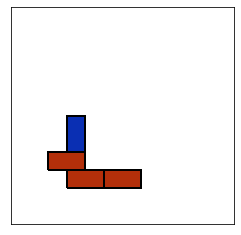

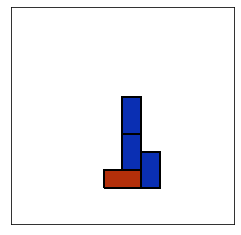

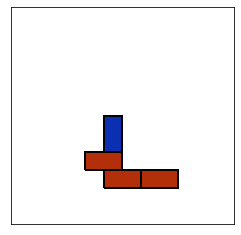

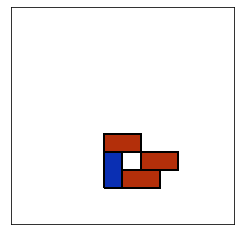

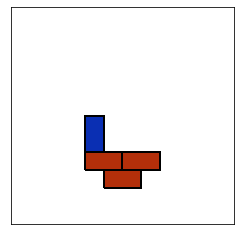

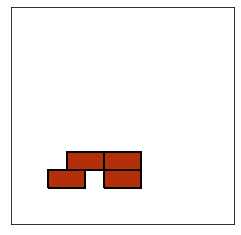

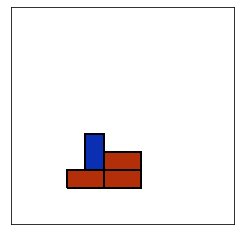

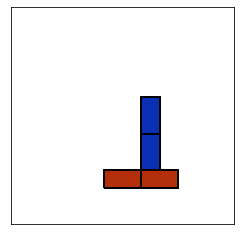

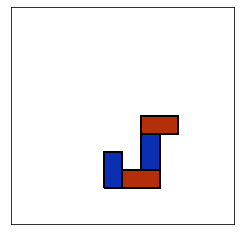

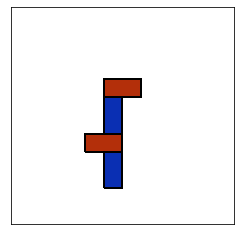

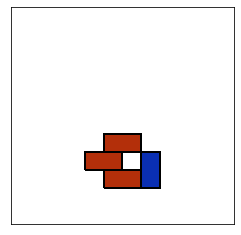

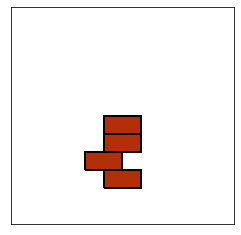

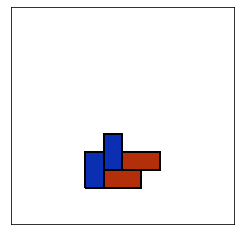

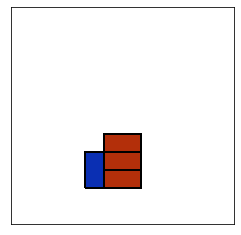

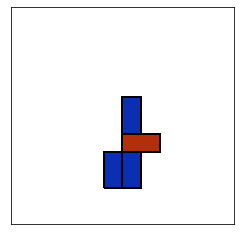

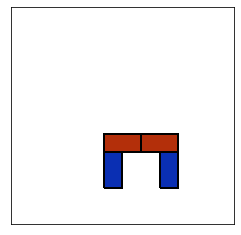

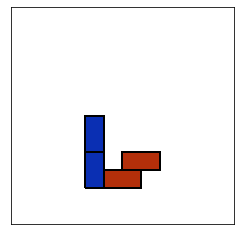

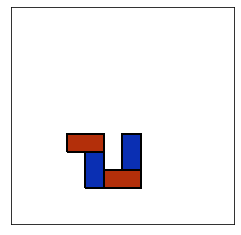

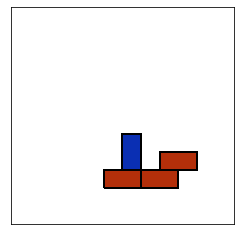

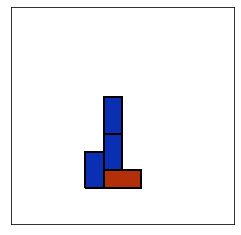

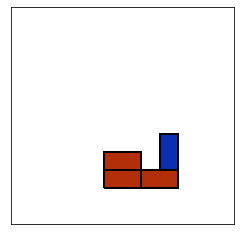

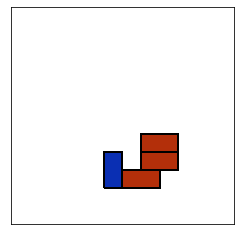

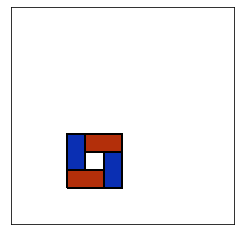

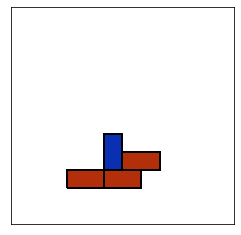

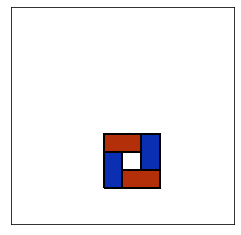

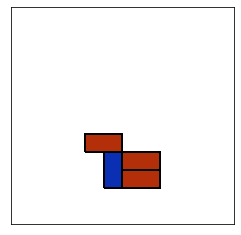

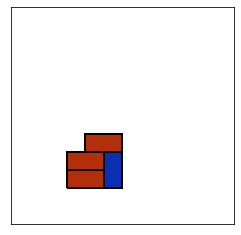

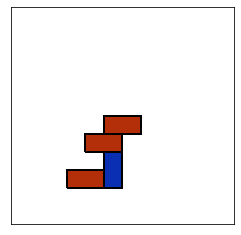

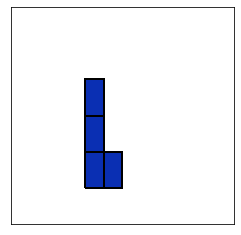

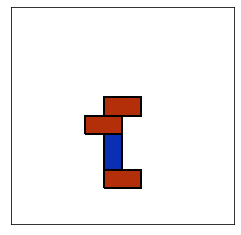

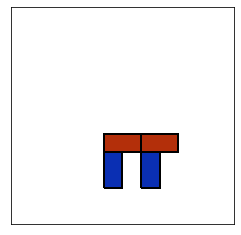

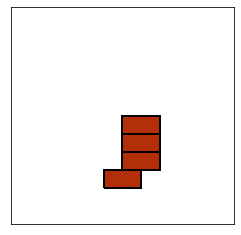

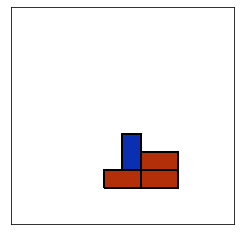

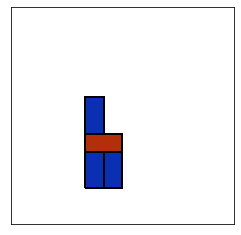

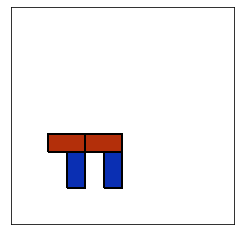

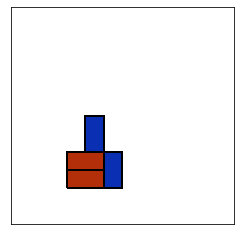

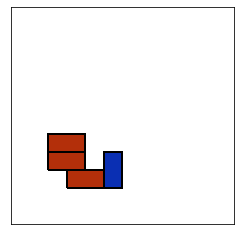

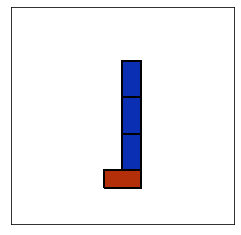

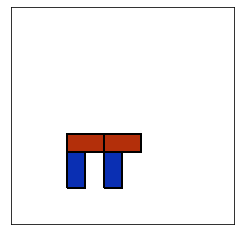

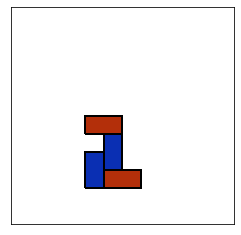

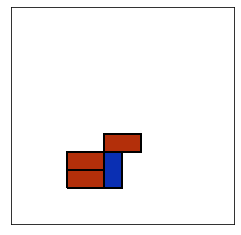

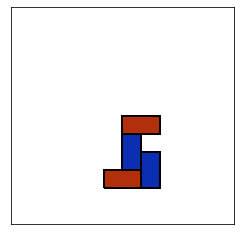

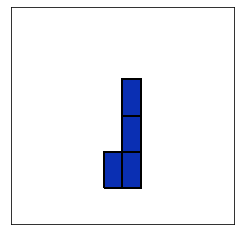

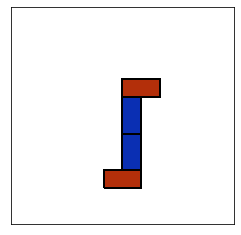

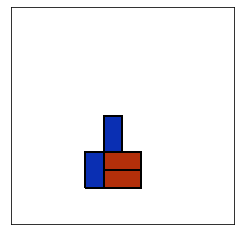

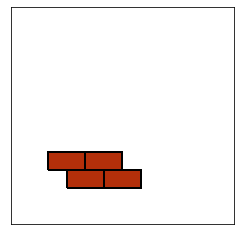

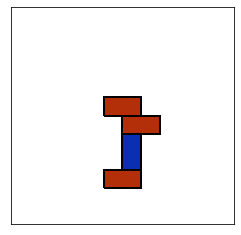

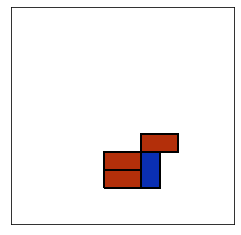

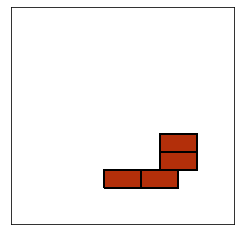

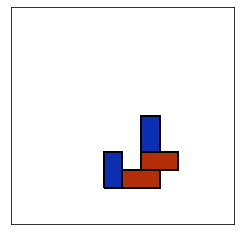

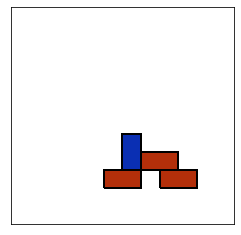

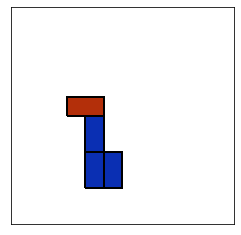

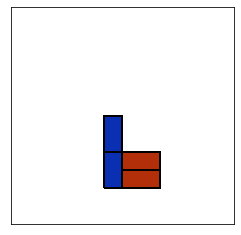

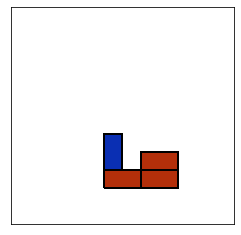

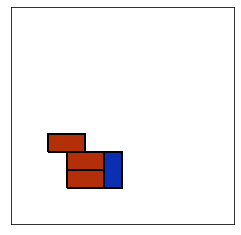

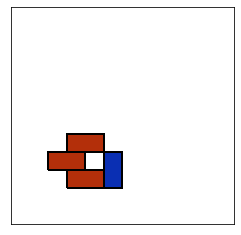

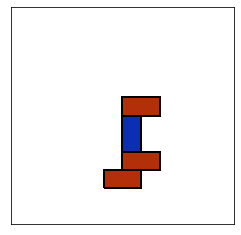

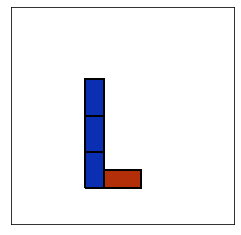

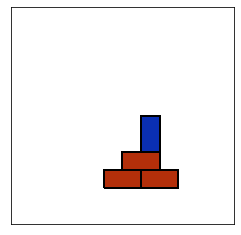

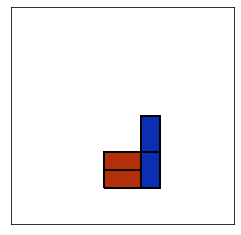

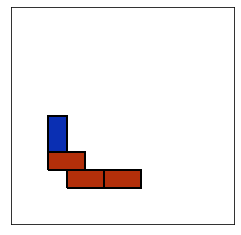

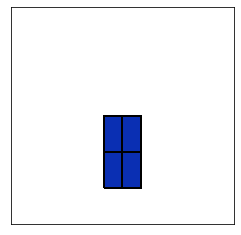

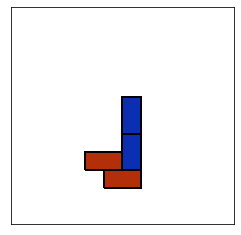

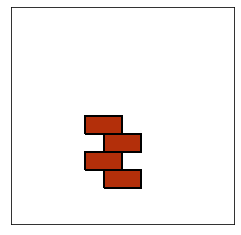

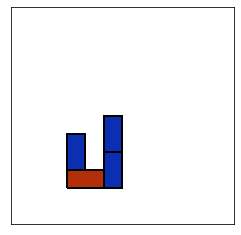

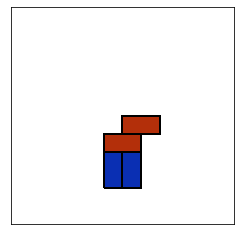

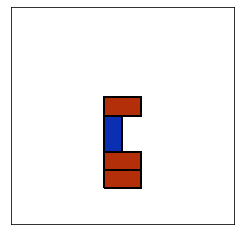

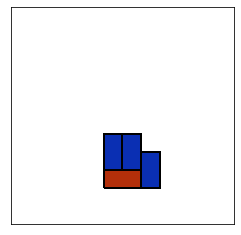

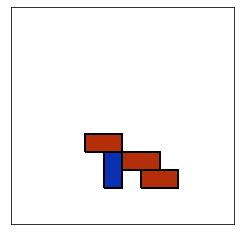

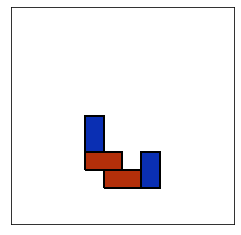

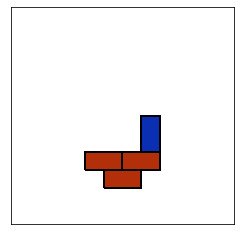

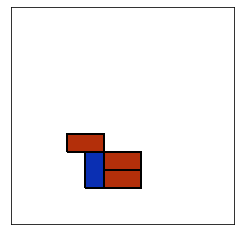

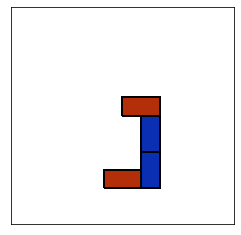

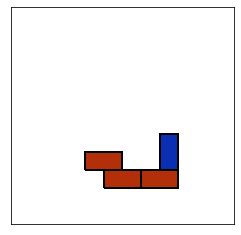

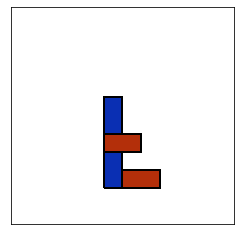

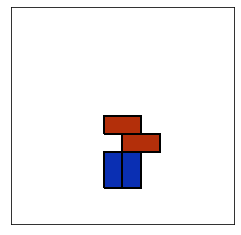

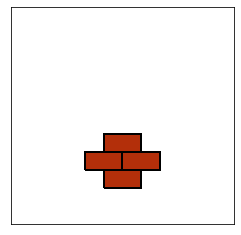

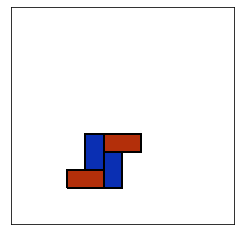

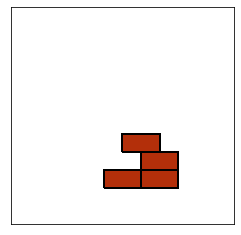

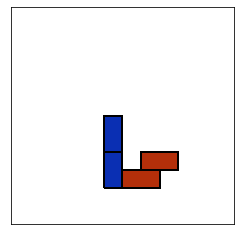

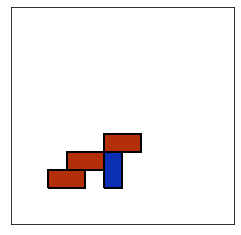

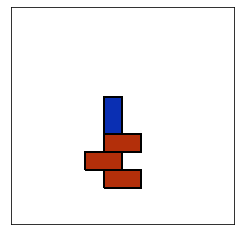

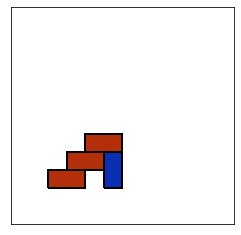

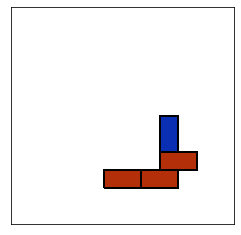

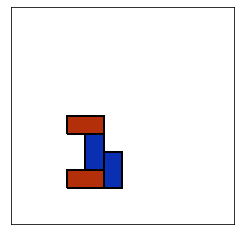

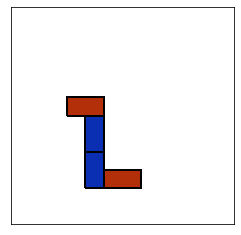

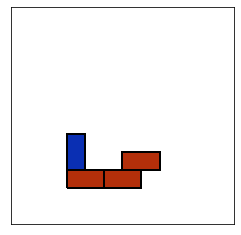

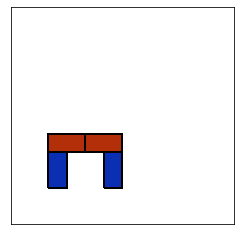

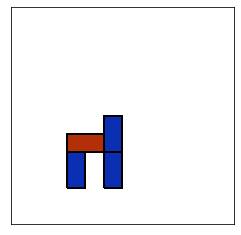

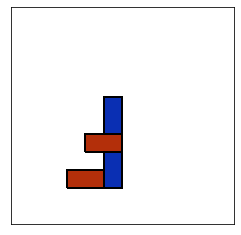

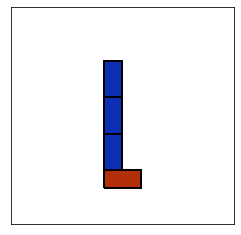

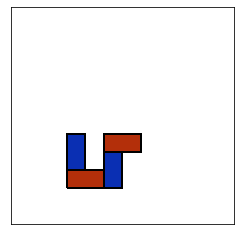

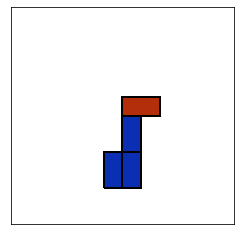

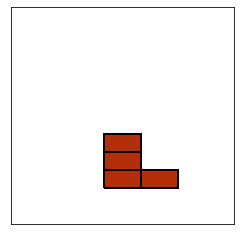

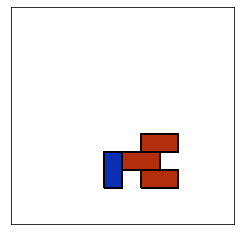

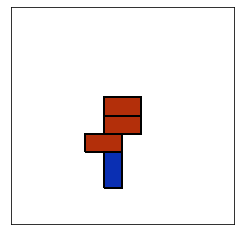

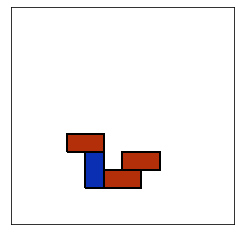

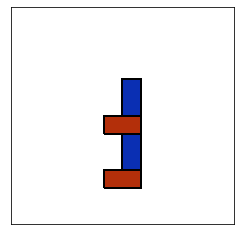

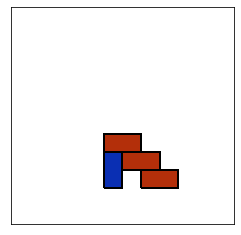

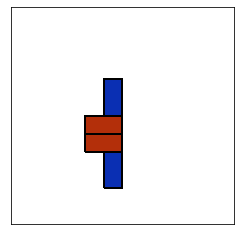

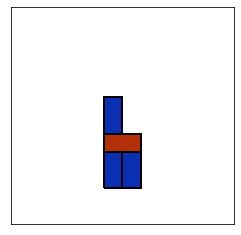

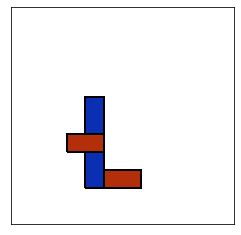

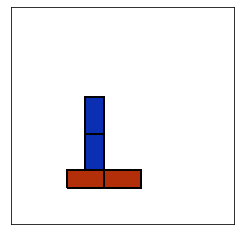

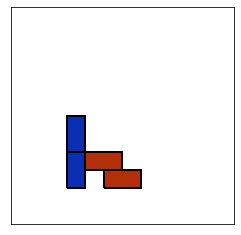

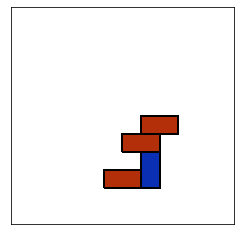

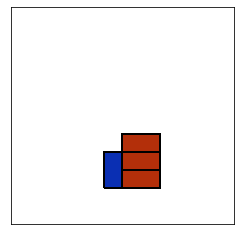

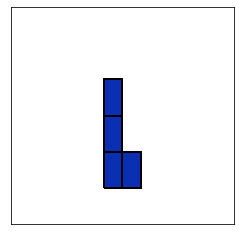

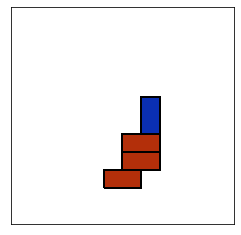

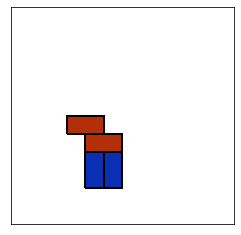

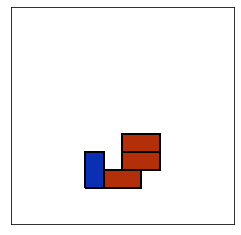

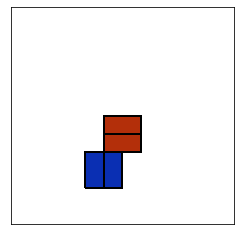

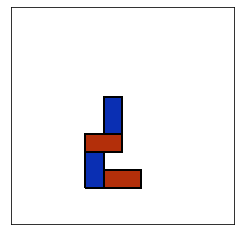

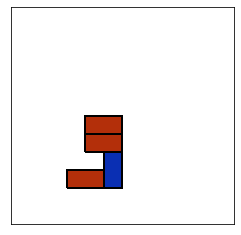

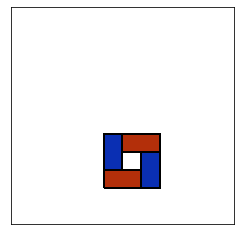

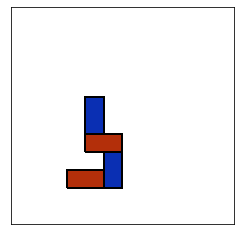

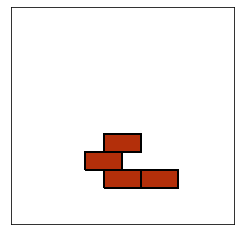

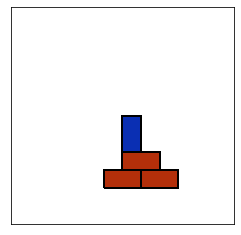

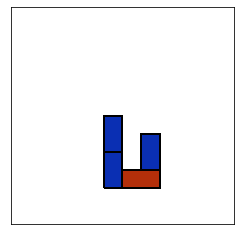

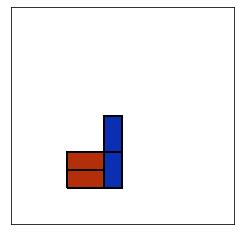

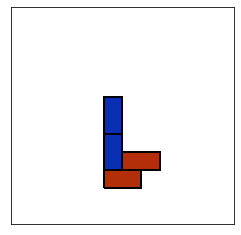

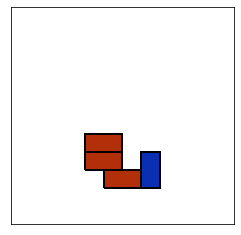

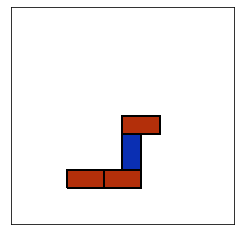

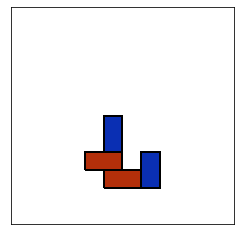

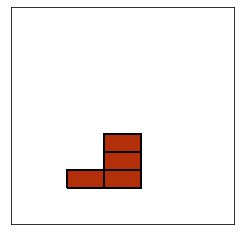

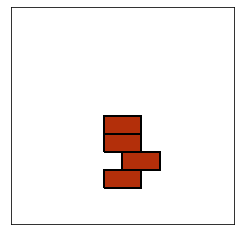

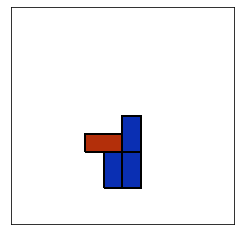

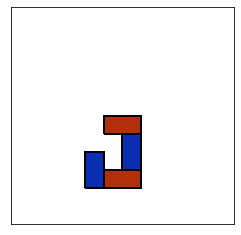

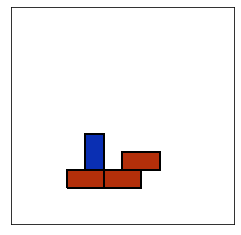

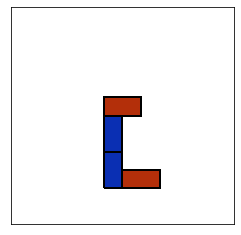

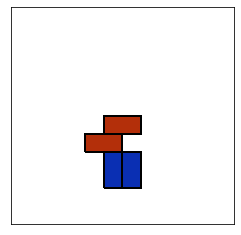

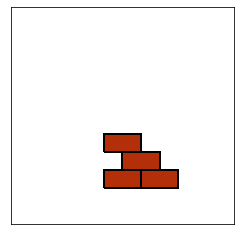

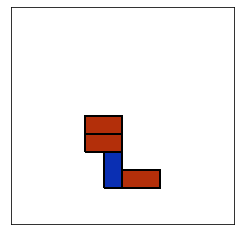

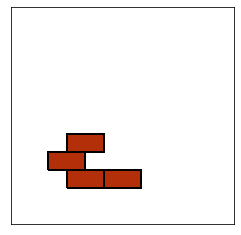

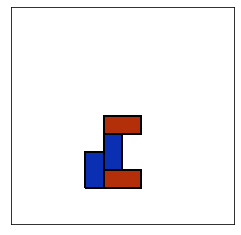

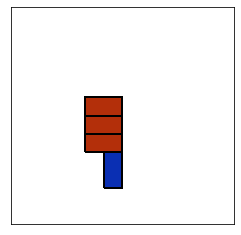

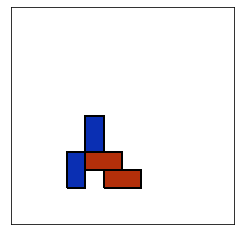

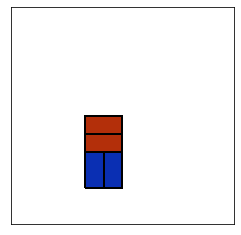

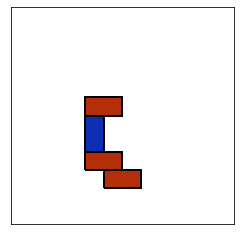

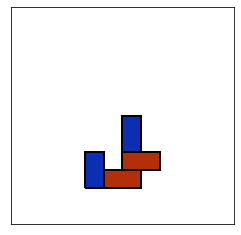

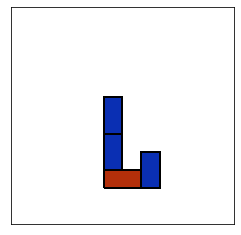

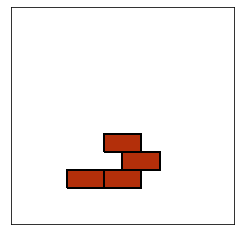

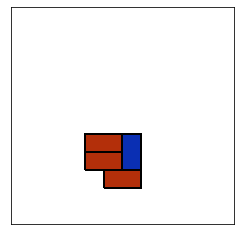

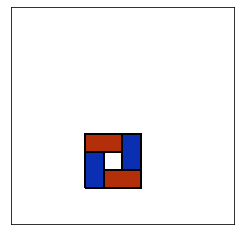

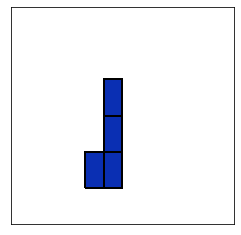

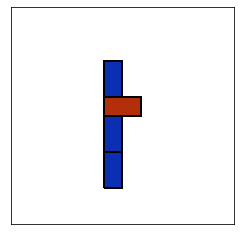

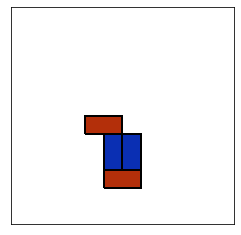

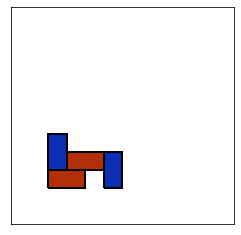

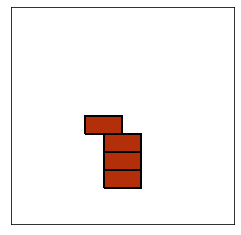

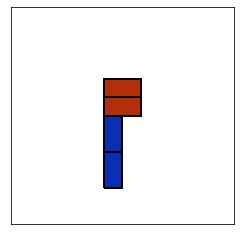

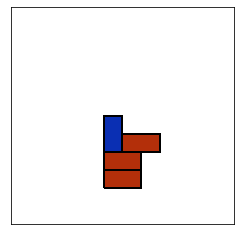

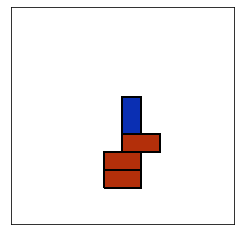

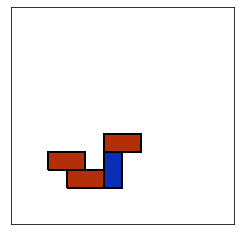

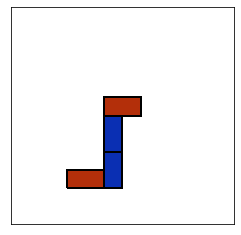

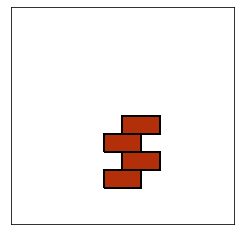

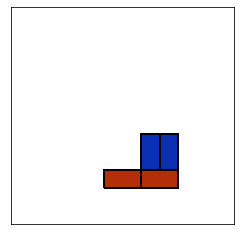

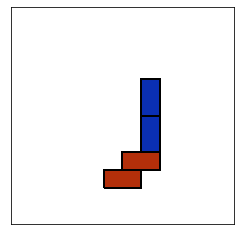

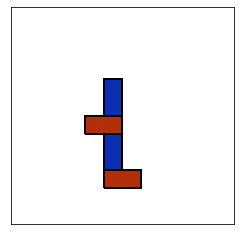

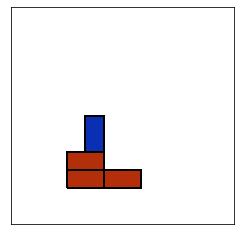

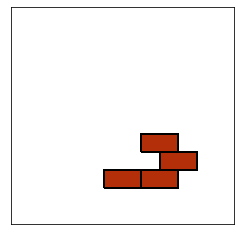

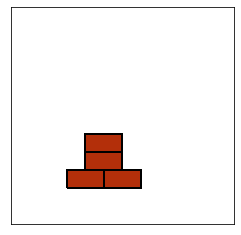

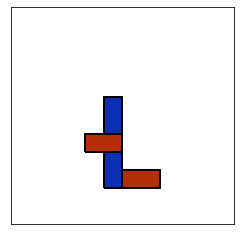

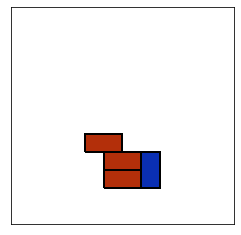

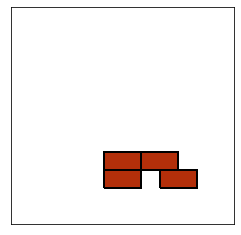

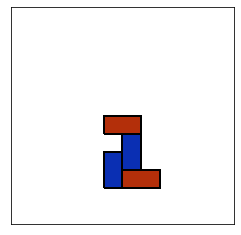

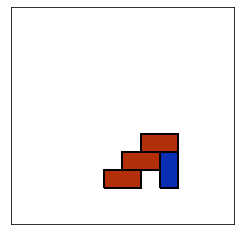

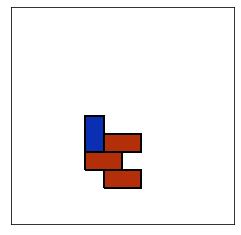

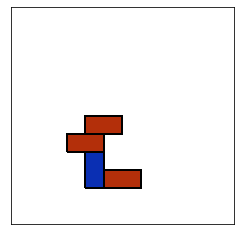

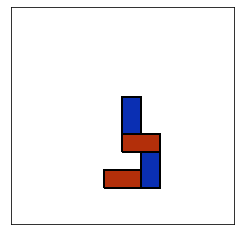

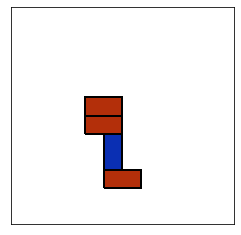

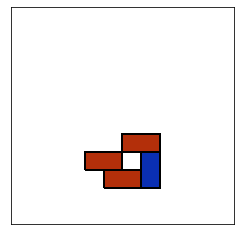

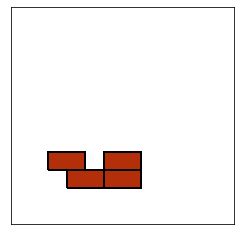

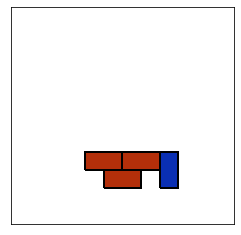

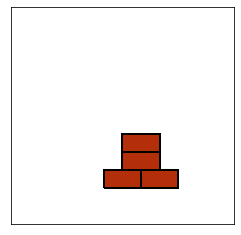

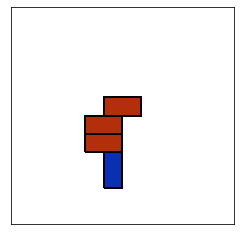

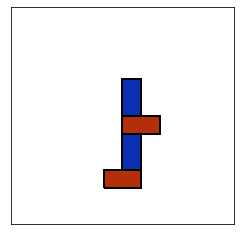

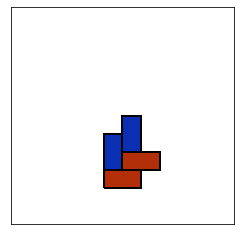

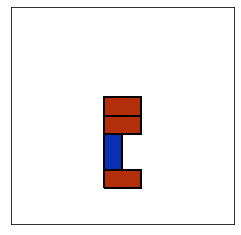

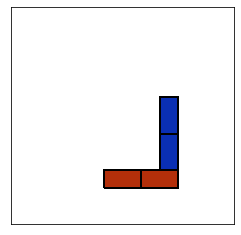

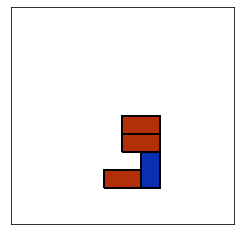

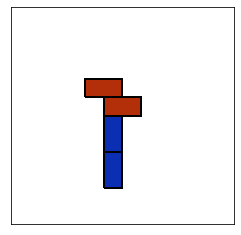

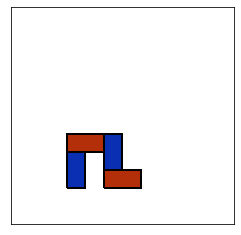

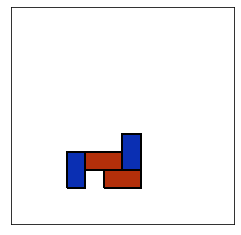

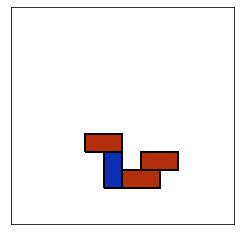

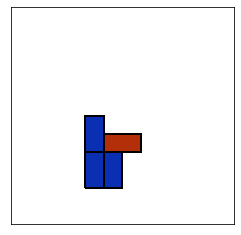

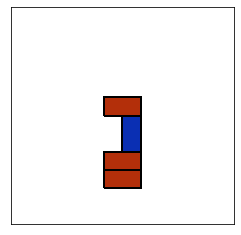

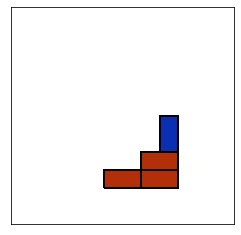

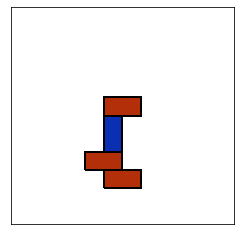

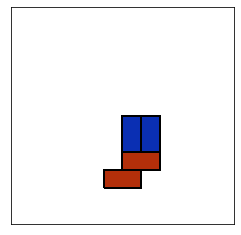

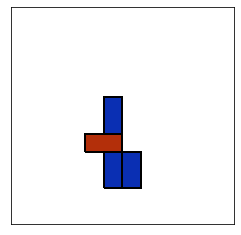

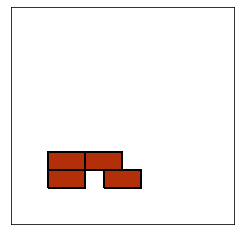

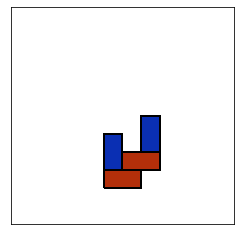

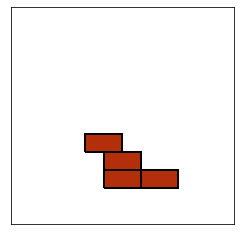

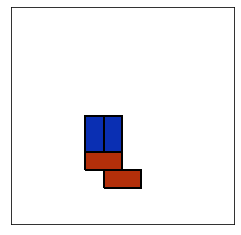

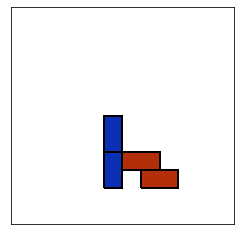

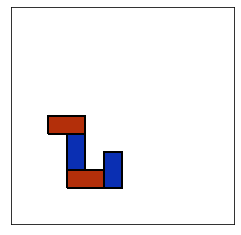

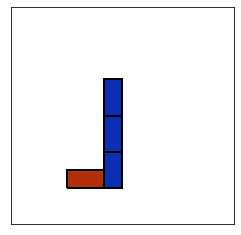

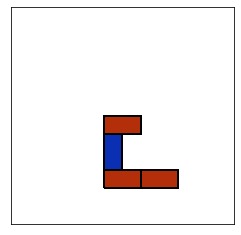

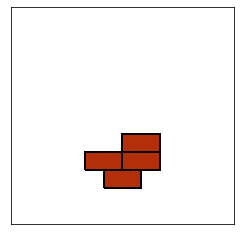

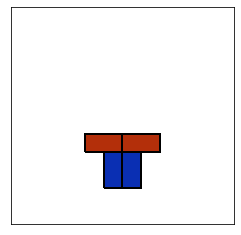

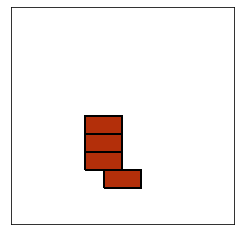

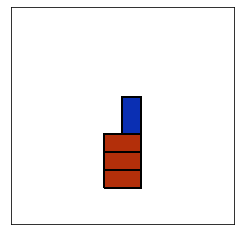

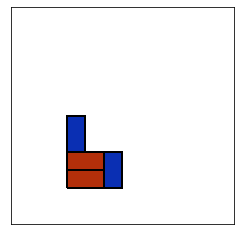

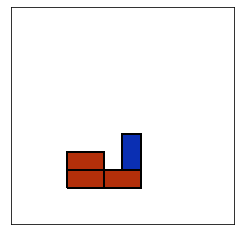

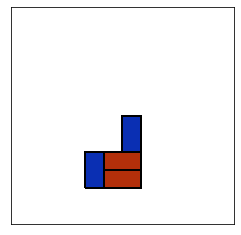

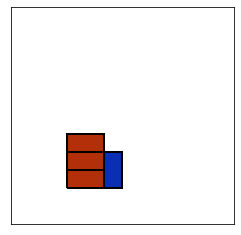

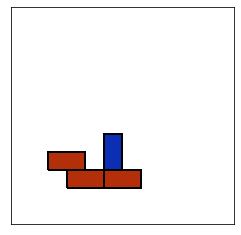

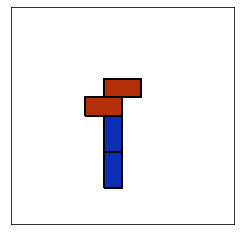

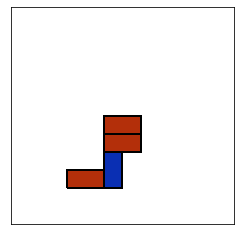

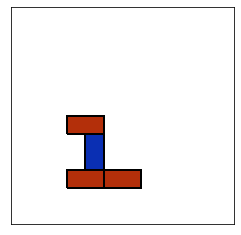

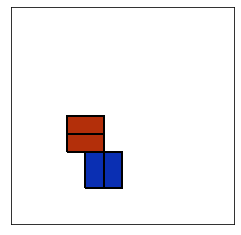

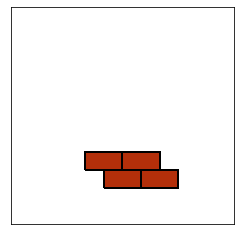

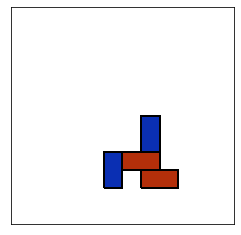

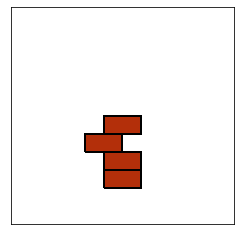

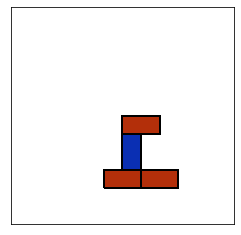

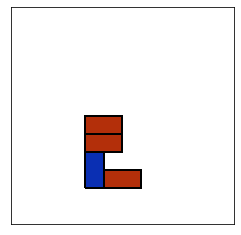

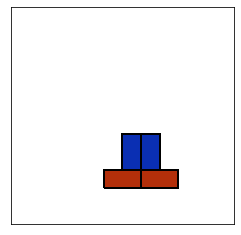

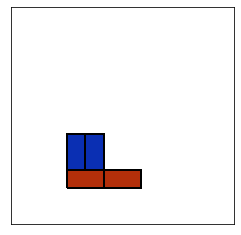

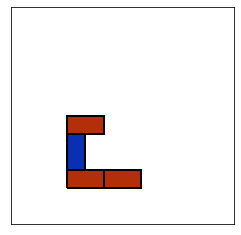

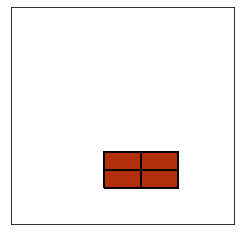

In [241]:
for blocks in towers_with_n_blocks_supported:
    w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
    w.populate_from_block_list(blocks)
#     print(w.fully_connected())
    utils.draw_world(w)

In [ ]:
# next task: translational invariance


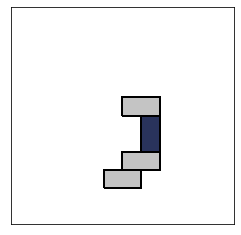

False

In [224]:
w = utils.worldify(unique_towers_dicts[3])
utils.draw_world(w)
w.blocks_above_ground(4)